<a href="https://colab.research.google.com/github/jiho-kang/RecSys_yes24_CB_CF/blob/main/RecSys_project_1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import sqlite3
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 3.9 MB/s 


In [ ]:
a = ['df_book_ori', 'df_category_ori', 'df_review_ori', 'df_book_1_nlp']
file = []
for i in a:
  path = f'/content/drive/MyDrive/AI 부트캠프/Project1/{i}.pkl'
  with open(path, 'rb') as fh:
    file.append(pickle.load(fh))

df_book_original = pd.DataFrame(file[0])
df_category_original = pd.DataFrame(file[1])
df_review_original = pd.DataFrame(file[2])
df_book_1_nlp = pd.DataFrame(file[3])

print('df_book_original의 길이:', len(df_book_original))
print('df_category_original 길이:', len(df_category_original))
print('df_review_original 길이:', len(df_review_original))
df_review_original.head()

df_book_original의 길이: 5398
df_category_original 길이: 26
df_review_original 길이: 316133


,index,book_id,reviewer_id,reviewer,rate,review
0,0,105536311,9379785,용*,평점5점,정발되기만을 손꼽아 기다렸습니다! 이렇게나마 렌고쿠를 볼 수 있어서 좋았어요.. 귀...
1,1,105536311,15192997,작***리,평점5점,귀멸의 칼날 외전으로 다시 귀멸의 칼날을 만날 수 있어 좋다. 일단 만화는 성공적으...
2,2,105536311,16853388,쿠*,평점5점,귀멸의 칼날의 애니메이션이 몇 달 전부터 시작되었고 2주 전부터는 새로운 유곽편이 ...
3,3,105536311,5970460,카**스,평점5점,귀멸의 칼날 극장판의 흥행에 크게 성공하면서 귀멸의 칼날은 전국적으로 인기를 끌게 ...
4,4,105536311,9155449,b*****o,평점5점,안녕하세요. 제가 이번에 리뷰할 만화는 고토게 코요하루 작가님의 '귀멸의 칼날' 외...


## 전처리 및 분석

### category table

In [ ]:
# 전체 중복 제거
print('카테고리 갯수 (중복 제거 전): ', len(df_category_original))
df_category_original.drop_duplicates(inplace=True)
print('카테고리 갯수 (중복 제거 후): ', len(df_category_original))
print(df_category_original.category_name)

카테고리 갯수 (중복 제거 전):  26
카테고리 갯수 (중복 제거 후):  26
0         가정 살림
1         건강 취미
2         경제 경영
3     국어 외국어 사전
4          대학교재
5      만화/라이트노벨
6         사회 정치
7       소설/시/희곡
8       수험서 자격증
9           어린이
10          에세이
11           여행
12           역사
13           예술
14           유아
15           인문
16           인물
17         자기계발
18         자연과학
19           잡지
20           전집
21           종교
22          청소년
23       IT 모바일
24        초등참고서
25       중고등참고서
Name: category_name, dtype: object


### book table

#### 전처리

In [ ]:
df_book_original.head()

,index,id,name,nameE,writer,data,category1,category2,summary,price,rate,date
0,0,105536311,귀멸의 칼날 외전,None,고토게 코요하루,NaN,만화/라이트노벨,판타지,수주(水柱) 토미오카가 만난 마타기 소녀 야에는 아버지의 원수를 갚기 위해 산으로 ...,"6,000원",10.0,2021년 12월 13일
1,1,105518025,도쿄 리벤저스 17,,와쿠이 켄,NaN,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제17권!! 이누이의 청을 받아들여 11대 흑룡 총장이 된...,"5,000원",10.0,2021년 12월 10일
2,2,105518067,도쿄 리벤저스 18,,와쿠이 켄,NaN,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제18권!!\n\n전의를 잃은 마이키가 빠진 상태에서 천축...,"5,000원",9.7,2021년 12월 10일
3,3,105484199,나의 히어로 아카데미아 32 일반판,None,호리코시 코헤이,NaN,만화/라이트노벨,액션,각지의 교도소에서 도망친 탈옥수들이 거리에서 날뛰고 있나봐요. 톱히어로들과 함께 행...,"5,000원",,2021년 12월 31일
4,4,105245181,원피스 ONE PIECE 100,패왕색,오다 에이이치로,NaN,만화/라이트노벨,액션,"주역급이 한데 모인 옥상에서, 카이도 & 빅 맘에게 도전하는 루피 일행. 최강 동맹...","5,500원",9.6,2021년 12월 09일


In [ ]:
import copy
df_book = df_book_original.copy()

# 이상한 열 삭제
df_book.drop(columns=['index','data'], inplace=True)

# 중복된 책 제거
print('책 갯수 (중복 제거 전): ', len(df_book))
df_book.drop_duplicates(['id', 'name'],inplace=True)
print('책 갯수 (중복 제거 후): ', len(df_book))

# id : astype(int)
df_book.id = df_book.id.astype(int)

# price : 15,000원 -> 15000 int로 변경
df_book_price_array = df_book.price.str.replace(',','').str.replace('원','')
df_book.price = df_book_price_array.astype(float)

# rate : astype(float), 이상치(할인가격으로 들어온 데이터) None처리
def df_book_rate_(x):
  try:
    float(x)
    return float(x)
  except:
    return None
df_book.rate = df_book.rate.apply(df_book_rate_)

# data : 2021년 01월 01일 -> 2021-01-01 data type으로 변경
df_book.date = df_book.date.str.replace('년 ', '-').str.replace('월 ', '-').str.replace('일', '-')
df_book.date = pd.to_datetime(df_book.date)

df_book.info()

책 갯수 (중복 제거 전):  5398
책 갯수 (중복 제거 후):  5261
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5261 entries, 0 to 5397
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         5261 non-null   int64         
 1   name       5261 non-null   object        
 2   nameE      2962 non-null   object        
 3   writer     5149 non-null   object        
 4   category1  5261 non-null   object        
 5   category2  5260 non-null   object        
 6   summary    5027 non-null   object        
 7   price      5259 non-null   float64       
 8   rate       4257 non-null   float64       
 9   date       5149 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 452.1+ KB


In [ ]:
df_book.head()

,id,name,nameE,writer,category1,category2,summary,price,rate,date
0,105536311,귀멸의 칼날 외전,None,고토게 코요하루,만화/라이트노벨,판타지,수주(水柱) 토미오카가 만난 마타기 소녀 야에는 아버지의 원수를 갚기 위해 산으로 ...,6000.0,10.0,2021-12-13
1,105518025,도쿄 리벤저스 17,,와쿠이 켄,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제17권!! 이누이의 청을 받아들여 11대 흑룡 총장이 된...,5000.0,10.0,2021-12-10
2,105518067,도쿄 리벤저스 18,,와쿠이 켄,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제18권!!\n\n전의를 잃은 마이키가 빠진 상태에서 천축...,5000.0,9.7,2021-12-10
3,105484199,나의 히어로 아카데미아 32 일반판,None,호리코시 코헤이,만화/라이트노벨,액션,각지의 교도소에서 도망친 탈옥수들이 거리에서 날뛰고 있나봐요. 톱히어로들과 함께 행...,5000.0,NaN,2021-12-31
4,105245181,원피스 ONE PIECE 100,패왕색,오다 에이이치로,만화/라이트노벨,액션,"주역급이 한데 모인 옥상에서, 카이도 & 빅 맘에게 도전하는 루피 일행. 최강 동맹...",5500.0,9.6,2021-12-09


#### 분석

In [ ]:
# df_book columns
df_book_columns = list(df_book.columns)
print('df_book 칼럼:', df_book_columns)

# 카테고리
df_book_category = df_book.category1.unique()
print('\n\n카테고리:', df_book_category)

# 카테고리 내 책 갯수
df_book_category_books = len(df_book.name.unique())
print('\n\n카테고리에서 수집한 책 갯수:', df_book_category_books)

df_book.head()

df_book 칼럼: ['id', 'name', 'nameE', 'writer', 'category1', 'category2', 'summary', 'price', 'rate', 'date']


카테고리: ['만화/라이트노벨' '에세이' '역사' '유아' '인물' '자기계발' '자연과학' '가정 살림' '경제 경영' '대학교재'
 '소설/시/희곡' '수험서 자격증' '청소년' '초등참고서']


카테고리에서 수집한 책 갯수: 5239


,id,name,nameE,writer,category1,category2,summary,price,rate,date
0,105536311,귀멸의 칼날 외전,None,고토게 코요하루,만화/라이트노벨,판타지,수주(水柱) 토미오카가 만난 마타기 소녀 야에는 아버지의 원수를 갚기 위해 산으로 ...,6000.0,10.0,2021-12-13
1,105518025,도쿄 리벤저스 17,,와쿠이 켄,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제17권!! 이누이의 청을 받아들여 11대 흑룡 총장이 된...,5000.0,10.0,2021-12-10
2,105518067,도쿄 리벤저스 18,,와쿠이 켄,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제18권!!\n\n전의를 잃은 마이키가 빠진 상태에서 천축...,5000.0,9.7,2021-12-10
3,105484199,나의 히어로 아카데미아 32 일반판,None,호리코시 코헤이,만화/라이트노벨,액션,각지의 교도소에서 도망친 탈옥수들이 거리에서 날뛰고 있나봐요. 톱히어로들과 함께 행...,5000.0,NaN,2021-12-31
4,105245181,원피스 ONE PIECE 100,패왕색,오다 에이이치로,만화/라이트노벨,액션,"주역급이 한데 모인 옥상에서, 카이도 & 빅 맘에게 도전하는 루피 일행. 최강 동맹...",5500.0,9.6,2021-12-09


In [ ]:
# 카테고리별 책 갯수
k = df_book.groupby(['category1']).size().sort_values(ascending=False)
k = pd.DataFrame(k).reset_index()
k

,category1,0
0,자연과학,849
1,수험서 자격증,648
2,에세이,497
3,대학교재,471
4,유아,459
5,인물,440
6,가정 살림,406
7,역사,400
8,만화/라이트노벨,352
9,경제 경영,313


In [ ]:
k.iloc[:, 1].sum()

5261

In [ ]:
k.i

RangeIndex(start=0, stop=14, step=1)

In [ ]:
k = k.append({k.columns[0]:'총합', k.columns[1]:k.iloc[:, 1].sum()}, ignore_index=True)
k

,category1,0
0,자연과학,849
1,수험서 자격증,648
2,에세이,497
3,대학교재,471
4,유아,459
5,인물,440
6,가정 살림,406
7,역사,400
8,만화/라이트노벨,352
9,경제 경영,313


price
1990.0      3
2500.0      2
3000.0      3
3300.0      1
3500.0      1
           ..
170000.0    1
185000.0    1
248000.0    1
280000.0    1
320000.0    1
Length: 204, dtype: int64


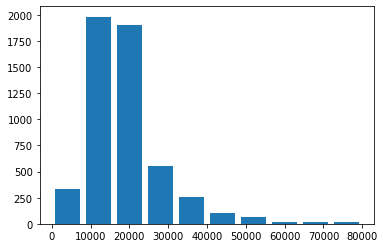

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# price의 범위
print(df_book.groupby('price').size())
plt.hist(df_book.price, range=(0,80000), rwidth=0.8)
# plt.size(15,10)
plt.show()

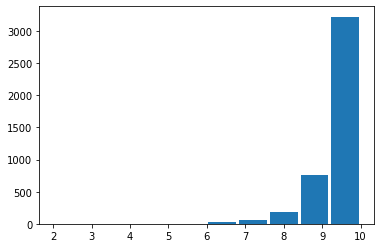

In [ ]:
# rate 범위
# df_book.groupby('rate').size().plot(kind='bar', figsize=(10,7), fontsize=10)

plt.hist(df_book.rate, rwidth=0.9)
plt.show()

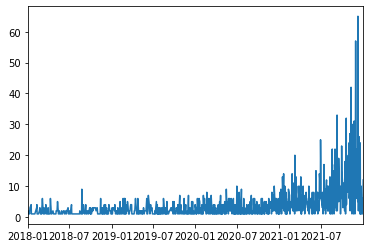

In [ ]:
import datetime
plt.plot(df_book.groupby('date').size())
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2021,12,31)])
plt.show()

### review table

#### 전처리

In [ ]:
df_review = df_review_original.copy()
df_review.head()

,index,book_id,reviewer_id,reviewer,rate,review
0,0,105536311,9379785,용*,평점5점,정발되기만을 손꼽아 기다렸습니다! 이렇게나마 렌고쿠를 볼 수 있어서 좋았어요.. 귀...
1,1,105536311,15192997,작***리,평점5점,귀멸의 칼날 외전으로 다시 귀멸의 칼날을 만날 수 있어 좋다. 일단 만화는 성공적으...
2,2,105536311,16853388,쿠*,평점5점,귀멸의 칼날의 애니메이션이 몇 달 전부터 시작되었고 2주 전부터는 새로운 유곽편이 ...
3,3,105536311,5970460,카**스,평점5점,귀멸의 칼날 극장판의 흥행에 크게 성공하면서 귀멸의 칼날은 전국적으로 인기를 끌게 ...
4,4,105536311,9155449,b*****o,평점5점,안녕하세요. 제가 이번에 리뷰할 만화는 고토게 코요하루 작가님의 '귀멸의 칼날' 외...


In [ ]:
# 전체 데이터 중복 제거
print('리뷰 갯수 (중복 제거 전): ', len(df_review))
df_review.drop_duplicates(['book_id', 'reviewer_id'], inplace=True)
print('리뷰 갯수 (중복 제거 후): ', len(df_review))


# book_id astype(int)
df_review.book_id = df_review.book_id.astype(int)

# reviewr_id astype(int)
df_review.reviewer_id = df_review.reviewer_id.astype(int)

# rate => rate가 없다고 drop 보다, implicit data로 사용하기
def df_review_rate_(x):
  score = x.replace('평점', '').replace('점', '')
  try:
    float(score)
    return float(score)
  except:
    return None
df_review.rate = df_review.rate.apply(df_review_rate_).astype(float)

df_review.info()
df_review.head()

리뷰 갯수 (중복 제거 전):  316133
리뷰 갯수 (중복 제거 후):  246753
<class 'pandas.core.frame.DataFrame'>
Int64Index: 246753 entries, 0 to 316132
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        246753 non-null  int64  
 1   book_id      246753 non-null  int64  
 2   reviewer_id  246753 non-null  int64  
 3   reviewer     246753 non-null  object 
 4   rate         202603 non-null  float64
 5   review       246753 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 13.2+ MB


,index,book_id,reviewer_id,reviewer,rate,review
0,0,105536311,9379785,용*,5.0,정발되기만을 손꼽아 기다렸습니다! 이렇게나마 렌고쿠를 볼 수 있어서 좋았어요.. 귀...
1,1,105536311,15192997,작***리,5.0,귀멸의 칼날 외전으로 다시 귀멸의 칼날을 만날 수 있어 좋다. 일단 만화는 성공적으...
2,2,105536311,16853388,쿠*,5.0,귀멸의 칼날의 애니메이션이 몇 달 전부터 시작되었고 2주 전부터는 새로운 유곽편이 ...
3,3,105536311,5970460,카**스,5.0,귀멸의 칼날 극장판의 흥행에 크게 성공하면서 귀멸의 칼날은 전국적으로 인기를 끌게 ...
4,4,105536311,9155449,b*****o,5.0,안녕하세요. 제가 이번에 리뷰할 만화는 고토게 코요하루 작가님의 '귀멸의 칼날' 외...


#### 분석

In [ ]:
# df_review columns
df_review_columns = list(df_review.columns)
print('df_review 칼럼:', df_review_columns)

# 수집한 리뷰 갯수
print('수집한 리뷰 갯수:', len(df_review))

# 수집한 리뷰의 책 갯수
df_review_books = len(df_review.book_id.unique())
print('수집한 리뷰의 책 갯수:', df_review_books)

# 리뷰 남긴 사람 수
total_reviewer = df_review.reviewer_id.unique()
print('리뷰 남긴 사람 수:', len(total_reviewer))

df_review.head()

df_review 칼럼: ['index', 'book_id', 'reviewer_id', 'reviewer', 'rate', 'review']
수집한 리뷰 갯수: 246753
수집한 리뷰의 책 갯수: 4598
리뷰 남긴 사람 수: 89865


,index,book_id,reviewer_id,reviewer,rate,review
0,0,105536311,9379785,용*,5.0,정발되기만을 손꼽아 기다렸습니다! 이렇게나마 렌고쿠를 볼 수 있어서 좋았어요.. 귀...
1,1,105536311,15192997,작***리,5.0,귀멸의 칼날 외전으로 다시 귀멸의 칼날을 만날 수 있어 좋다. 일단 만화는 성공적으...
2,2,105536311,16853388,쿠*,5.0,귀멸의 칼날의 애니메이션이 몇 달 전부터 시작되었고 2주 전부터는 새로운 유곽편이 ...
3,3,105536311,5970460,카**스,5.0,귀멸의 칼날 극장판의 흥행에 크게 성공하면서 귀멸의 칼날은 전국적으로 인기를 끌게 ...
4,4,105536311,9155449,b*****o,5.0,안녕하세요. 제가 이번에 리뷰할 만화는 고토게 코요하루 작가님의 '귀멸의 칼날' 외...


In [ ]:
df_review_count = pd.DataFrame(df_review.reviewer_id.value_counts())
df_review_count_2 = df_review_count[df_review_count.reviewer_id > 1]
df_review_count_3 = df_review_count[df_review_count.reviewer_id > 2]
df_review_count_4 = df_review_count[df_review_count.reviewer_id > 3]

print('리뷰 남긴 사람:', len(df_review_count))
print('리뷰 2개 이상 남긴 사람:', len(df_review_count_2))
print('리뷰 3개 이상 남긴 사람:', len(df_review_count_3))
print('리뷰 4개 이상 남긴 사람:', len(df_review_count_4))

리뷰 남긴 사람: 89865
리뷰 2개 이상 남긴 사람: 31318
리뷰 3개 이상 남긴 사람: 18948
리뷰 4개 이상 남긴 사람: 13485


### 테이블 병합

In [ ]:
df_book.head(5)

,id,name,nameE,writer,category1,category2,summary,price,rate,date
0,105536311,귀멸의 칼날 외전,None,고토게 코요하루,만화/라이트노벨,판타지,수주(水柱) 토미오카가 만난 마타기 소녀 야에는 아버지의 원수를 갚기 위해 산으로 ...,6000.0,10.0,2021-12-13
1,105518025,도쿄 리벤저스 17,,와쿠이 켄,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제17권!! 이누이의 청을 받아들여 11대 흑룡 총장이 된...,5000.0,10.0,2021-12-10
2,105518067,도쿄 리벤저스 18,,와쿠이 켄,만화/라이트노벨,액션,최신 타임 슬립 서스펜스 제18권!!\n\n전의를 잃은 마이키가 빠진 상태에서 천축...,5000.0,9.7,2021-12-10
3,105484199,나의 히어로 아카데미아 32 일반판,None,호리코시 코헤이,만화/라이트노벨,액션,각지의 교도소에서 도망친 탈옥수들이 거리에서 날뛰고 있나봐요. 톱히어로들과 함께 행...,5000.0,NaN,2021-12-31
4,105245181,원피스 ONE PIECE 100,패왕색,오다 에이이치로,만화/라이트노벨,액션,"주역급이 한데 모인 옥상에서, 카이도 & 빅 맘에게 도전하는 루피 일행. 최강 동맹...",5500.0,9.6,2021-12-09


In [ ]:
df_review.head()

,index,book_id,reviewer_id,reviewer,rate,review
0,0,105536311,9379785,용*,5.0,정발되기만을 손꼽아 기다렸습니다! 이렇게나마 렌고쿠를 볼 수 있어서 좋았어요.. 귀...
1,1,105536311,15192997,작***리,5.0,귀멸의 칼날 외전으로 다시 귀멸의 칼날을 만날 수 있어 좋다. 일단 만화는 성공적으...
2,2,105536311,16853388,쿠*,5.0,귀멸의 칼날의 애니메이션이 몇 달 전부터 시작되었고 2주 전부터는 새로운 유곽편이 ...
3,3,105536311,5970460,카**스,5.0,귀멸의 칼날 극장판의 흥행에 크게 성공하면서 귀멸의 칼날은 전국적으로 인기를 끌게 ...
4,4,105536311,9155449,b*****o,5.0,안녕하세요. 제가 이번에 리뷰할 만화는 고토게 코요하루 작가님의 '귀멸의 칼날' 외...


In [ ]:
# df_book의 id 기준으로 리뷰 갯수를 count하여 데이터 추가
def review_count(id):
  count = len(df_review[df_review.book_id==id])
  return count

df_book['review_count'] = df_book.id.apply(review_count)

df_book.sort_values('review_count', ascending=False).head()

,id,name,nameE,writer,category1,category2,summary,price,rate,date,review_count
4465,8157957,나미야 잡화점의 기적,None,히가시노 게이고,소설/시/희곡,일본소설,기적과 감동을 추리한다!\n히가시노 게이고의 차기 대표작으로 손꼽힐\n『나미야 잡화...,14800.0,9.3,2012-12-19,2263
859,29433467,설민석의 조선왕조실록,대한민국이 선택한 역사 이야기,설민석,역사,한국사/한국문화,대한민국 스타강사의 한 번쯤 꼭 들어보고 싶은 인문 역사 강의\n27명 조선의 리더...,22000.0,9.4,2016-07-25,1771
4551,17932082,[예스리커버] 오베라는 남자,None,프레드릭 배크만,소설/시/희곡,북유럽소설,"30초마다 웃음이 터지는 시한폭탄 같은 소설\n시종일관 유쾌하고, 불현듯 감동적인 ...",13800.0,9.1,2015-05-20,1624
674,24034748,완벽하지 않은 것들에 대한 사랑,온전한 나를 위한 혜민 스님의 따뜻한 응원,혜민,에세이,삶의 자세와 지혜,"“우리는 완벽하게 이해할 수는 없어도 온전하게 사랑할 수는 있습니다.”\n《멈추면,...",14800.0,9.3,2016-02-03,1597
2180,22793441,5년 후 나에게 Q&A a day (2022 메리골드 Edition),,포터 스타일,자기계발,성공학/경력관리,"미국·영국 아마존 500주 연속 베스트셀러\n전 세계에서 가장 사랑받는, 가장 아름...",16800.0,9.2,2021-11-29,1269


In [ ]:
df_book_category1 = df_book.groupby(['category1']).size()
df_book_category1

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

In [ ]:
df_book_category1['역사']

400

In [ ]:
category_sum = df_book.groupby(['category1']).sum().reset_index().sort_values('category1')
category_sum

,category1,id,price,rate,review_count
0,가정 살림,34026141662,7186000.0,3511.8,22677
1,경제 경영,26421110340,5706700.0,2740.3,25520
2,대학교재,33248041138,12888700.0,2463.6,2486
3,만화/라이트노벨,30835146020,3540700.0,2782.8,19555
4,소설/시/희곡,9338530349,2140300.0,1210.9,33763
5,수험서 자격증,65781043970,16594800.0,4222.1,8510
6,에세이,40788834918,7575500.0,4184.7,33161
7,역사,29744112705,8876700.0,3176.0,15577
8,유아,25600792682,6105230.0,4196.0,29109
9,인물,18869974511,8190400.0,2894.0,6950


In [ ]:
category_mean = df_book.groupby(['category1']).agg('mean').reset_index().sort_values('category1')
category_mean

,category1,id,price,rate,review_count
0,가정 살림,8.380823e+07,17699.507389,9.647802,55.854680
1,경제 경영,8.441249e+07,18232.268371,9.384589,81.533546
2,대학교재,7.059032e+07,27364.543524,9.367300,5.278132
3,만화/라이트노벨,8.759985e+07,10058.806818,9.662500,55.553977
4,소설/시/희곡,6.767051e+07,15509.420290,9.243511,244.659420
5,수험서 자격증,1.015140e+08,25609.259259,9.796056,13.132716
6,에세이,8.207009e+07,15242.454728,9.382735,66.722334
7,역사,7.436028e+07,22191.750000,9.313783,38.942500
8,유아,5.577515e+07,13359.365427,9.623853,63.418301
9,인물,4.288631e+07,18614.545455,8.823171,15.795455


In [ ]:
df_book_category = pd.concat([category_mean.drop(['id', 'review_count'], axis=1), category_sum['review_count']], axis=1)
df_book_category

,category1,price,rate,review_count
0,가정 살림,17699.507389,9.647802,22677
1,경제 경영,18232.268371,9.384589,25520
2,대학교재,27364.543524,9.367300,2486
3,만화/라이트노벨,10058.806818,9.662500,19555
4,소설/시/희곡,15509.420290,9.243511,33763
5,수험서 자격증,25609.259259,9.796056,8510
6,에세이,15242.454728,9.382735,33161
7,역사,22191.750000,9.313783,15577
8,유아,13359.365427,9.623853,29109
9,인물,18614.545455,8.823171,6950


In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

In [ ]:
df_book_category = pd.concat([category_mean.drop(['id', 'review_count'], axis=1), category_sum['review_count']], axis=1)
df_book_category['book_count'] = df_book.groupby('category1').size().values
df_book_category.rename({'price':'mean_price', 'rate':'mean_rate'})


,category1,price,rate,review_count,book_count
0,가정 살림,17699.507389,9.647802,22677,406
1,경제 경영,18232.268371,9.384589,25520,313
2,대학교재,27364.543524,9.367300,2486,471
3,만화/라이트노벨,10058.806818,9.662500,19555,352
4,소설/시/희곡,15509.420290,9.243511,33763,138
5,수험서 자격증,25609.259259,9.796056,8510,648
6,에세이,15242.454728,9.382735,33161,497
7,역사,22191.750000,9.313783,15577,400
8,유아,13359.365427,9.623853,29109,459
9,인물,18614.545455,8.823171,6950,440


In [ ]:
df_book_category.price = round(df_book_category.price).astype(int)
df_book_category.rate = round(df_book_category.rate,2)
k = df_book_category.sort_values(['rate', 'book_count'], ascending=False)
k

,category1,price,rate,review_count,book_count
5,수험서 자격증,25609,9.80,8510,648
13,초등참고서,12454,9.71,5246,71
3,만화/라이트노벨,10059,9.66,19555,352
0,가정 살림,17700,9.65,22677,406
8,유아,13359,9.62,29109,459
12,청소년,15333,9.44,4815,58
6,에세이,15242,9.38,33161,497
1,경제 경영,18232,9.38,25520,313
2,대학교재,27365,9.37,2486,471
10,자기계발,16294,9.36,17850,159


In [ ]:
k[['category1', 'rate']].sort_values('rate', ascending=False)

,category1,rate
5,수험서 자격증,9.80
13,초등참고서,9.71
3,만화/라이트노벨,9.66
0,가정 살림,9.65
8,유아,9.62
12,청소년,9.44
6,에세이,9.38
1,경제 경영,9.38
2,대학교재,9.37
10,자기계발,9.36


In [ ]:
k[['category1', 'book_count']].sort_values('book_count', ascending=False)

,category1,book_count
11,자연과학,849
5,수험서 자격증,648
6,에세이,497
2,대학교재,471
8,유아,459
9,인물,440
0,가정 살림,406
7,역사,400
3,만화/라이트노벨,352
1,경제 경영,313


## Simple Recommender
개인화 추천이 아닌, 대중적인 추천

평점 순 > 리뷰 갯수 순으로 정렬

In [ ]:
df_book.sort_values(['rate', 'review_count'], ascending=False).head(10)

,id,name,nameE,writer,category1,category2,summary,price,rate,date,review_count
3738,82957982,네이버쇼핑 스마트스토어로 상위노출 하라,"무조건 1페이지에 올려라, 그래야 산다!",김도균,경제 경영,마케팅/세일즈,"네이버쇼핑 1페이지 1위 상위노출 전략\n\n네이버쇼핑에서 ‘칫솔’, ‘핫팩’, ‘...",22000.0,10.0,2021-10-15,421
1979,43831285,페더그래피카,테니스 황제 로저 페더러의 그래픽 평전,마크 호지킨슨,인물,스포츠/오락기타,페더그래피카 홈페이지 : http://blog.naver.com/fedegraphi...,23000.0,10.0,2017-06-30,251
2297,97916497,당신의 생각을 정리해드립니다,인생을 바꾸는 생각정리스킬,복주환,자기계발,기획/정보/시간관리,대한민국 최고의 생각정리 컨설턴트 복주환이 알려주는\n돈과 운을 부르는 40가지 신...,16000.0,10.0,2021-03-16,229
314,102458652,청사과 낙원 시즌2. 1~3 세트,,청낙원,만화/라이트노벨,웹툰,"『청사과 낙원』은 네이버 시리즈 연재 웹툰으로, 전체 시즌 누적 다운로드 수 150...",42000.0,10.0,2021-07-14,181
3597,102725848,라미의 믿고 먹는 다이어트 레시피,41kg 감량! 체지방 30% 감소! 10년 경력 영양사 다이어터!,이주아,가정 살림,요리,41kg 감량! 체지방 30% 감소! 모태뚱뚱 영양사 다이어터 라미의\n15분 완성...,18000.0,10.0,2021-07-15,166
3666,103154621,아파트 청약 이렇게 쉬웠어?,"1년 만에 1,000명이 넘는 부린이를 청약 당첨으로 이끈 실전 노하우 대공개!",김태훈,경제 경영,투자/재테크,"청약 최고수를 만난 수천 명에게 집이 생겼다!\n가점이 낮아도, 이미 집이 있어도,...",18000.0,10.0,2021-08-13,164
1267,90461037,이파라파냐무냐무,,이지은,유아,4-6세,"마시멜로가 사는 평화로운 마을. 풍요로운 먹거리와 폭신한 땅, 느긋해서 잠이 솔솔 ...",15000.0,10.0,2020-06-10,162
1250,105021310,눈아이,,안녕달,유아,4-6세,한겨울을 포근하게 감싸는 마법 같은 상상\n『수박 수영장』 『당근 유치원』 작가 안...,15000.0,10.0,2021-11-26,144
1426,98831125,집 안에 무슨 일이?,None,카테리나 고렐리크,유아,4-6세,“으악! 집 안에 늑대가 있어.”\n보이는 모습이 전부는 아니야!\n\n창문으로 이...,15000.0,10.0,2021-03-26,105
5350,84673834,"뿌리깊은 초등국어 독해력 어휘편 4단계 (초등3,4학년)",사자성어·속담·관용어,마더텅 편집부,초등참고서,3학년,『뿌리깊은 초등국어 독해력 어휘편 사자성어·속담·관용어』는 하루 15분 초등국어 독...,9900.0,10.0,2019-12-02,104


# Content-Based Rec

In [ ]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5261 entries, 0 to 5397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            5261 non-null   int64         
 1   name          5261 non-null   object        
 2   nameE         2962 non-null   object        
 3   writer        5149 non-null   object        
 4   category1     5261 non-null   object        
 5   category2     5260 non-null   object        
 6   summary       5027 non-null   object        
 7   price         5259 non-null   float64       
 8   rate          4257 non-null   float64       
 9   date          5149 non-null   datetime64[ns]
 10  review_count  5261 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 493.2+ KB


In [ ]:
df_book_1 = df_book.dropna(subset=['summary'])[['name', 'summary']]
df_book_1.info()
df_book_1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5027 entries, 0 to 5397
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     5027 non-null   object
 1   summary  5027 non-null   object
dtypes: object(2)
memory usage: 117.8+ KB


,name,summary
0,귀멸의 칼날 외전,수주(水柱) 토미오카가 만난 마타기 소녀 야에는 아버지의 원수를 갚기 위해 산으로 ...
1,도쿄 리벤저스 17,최신 타임 슬립 서스펜스 제17권!! 이누이의 청을 받아들여 11대 흑룡 총장이 된...
2,도쿄 리벤저스 18,최신 타임 슬립 서스펜스 제18권!!\n\n전의를 잃은 마이키가 빠진 상태에서 천축...
3,나의 히어로 아카데미아 32 일반판,각지의 교도소에서 도망친 탈옥수들이 거리에서 날뛰고 있나봐요. 톱히어로들과 함께 행...
4,원피스 ONE PIECE 100,"주역급이 한데 모인 옥상에서, 카이도 & 빅 맘에게 도전하는 루피 일행. 최강 동맹..."
...,...,...
5393,EBS 매일 쉬운 스토리 한국사 1 (2022년용),"재미있는 이야기를 듣는 것처럼 가벼운 마음으로 스토리를 읽을 수 있고, 스토리 속 ..."
5394,"뿌리깊은 초등국어 독해력 어휘편 2단계 (초등1,2학년)",『뿌리깊은 초등국어 독해력 어휘편 사자성어·속담·관용어』는 하루 15분 초등국어 독...
5395,큐브수학 개념 초등 수학 6-1 (2022년),2022 새 교과서 완벽 반영! 수학 1등 되는 큐브수학 시리즈\n개념 설명 동영상...
5396,EBS 어휘가 독해다! 초등 국어 어휘 입문,초등 주간 베스트셀러 1위! 학부모가 먼저 알아보고 선택한 어휘 교재 No.1!\n...


In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 598 kB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 448 kB 58.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import re
from konlpy.tag import Okt

"""한글, 숫자, 영어 빼고 전부 제거"""
def sub_special(s):
  return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]','',str(s))

STOP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

def morph_and_stopword(s):
  token_ls = []
  #형태소 분석
  tmp = okt.morphs(s, stem=True)

  #불용어 처리
  for token in tmp:
    if token not in STOP_WORDS:
      token_ls.append(token)
  return token_ls


df_book_1.name = df_book.name.apply(sub_special)
df_book_1.summary = df_book.summary.apply(sub_special).apply(morph_and_stopword)
df_book_1.head()

KeyboardInterrupt: ignored

In [ ]:
df_book_1.head()

,name,summary
0,귀멸의 칼날 외전,"[수주, 토미, 오카, 만난, 마타, 기, 소녀, 야, 에는, 아버지, 원수, 갚다..."
1,도쿄 리벤저스 17,"[최신, 타임, 슬립, 서스펜스, 제, 17, 권, 이누이, 청, 을, 받아들이다,..."
2,도쿄 리벤저스 18,"[최신, 타임, 슬립, 서스펜스, 제, 18, 권, 전의, 잃다, 마이키, 빠지다,..."
3,나의 히어로 아카데미아 32 일반판,"[각지, 교도소, 에서, 도망치다, 탈, 옥수, 거리, 에서, 날뛰다, 있다, 보다..."
4,원피스 ONE PIECE 100,"[주역, 급, 한데, 모이다, 옥상, 에서, 카이, 빅, 맘, 에게, 도전, 루피,..."


In [ ]:
df_book_1['summary'] = df_book_1['summary'].apply(lambda x: ' '.join(map(str, x)))
df_book_1

,name,summary
0,귀멸의 칼날 외전,수주 토미 오카 만난 마타 기 소녀 야 에는 아버지 원수 갚다 위해 산 들어가다 그...
1,도쿄 리벤저스 17,최신 타임 슬립 서스펜스 제 17 권 이누이 청 을 받아들이다 11 대다 흑룡 총장...
2,도쿄 리벤저스 18,최신 타임 슬립 서스펜스 제 18 권 전의 잃다 마이키 빠지다 상태 에서 천축 치다...
3,나의 히어로 아카데미아 32 일반판,각지 교도소 에서 도망치다 탈 옥수 거리 에서 날뛰다 있다 보다 톱 히어로 함께 행...
4,원피스 ONE PIECE 100,주역 급 한데 모이다 옥상 에서 카이 빅 맘 에게 도전 루피 일행 최강 동맹 을 상...
...,...,...
5393,EBS 매일 쉬운 스토리 한국사 1 2022년용,재미있다 이야기 듣다 것 처럼 가볍다 마음 스토리 읽다 수 있다 스토리 속 중요 개...
5394,뿌리깊은 초등국어 독해력 어휘편 2단계 초등12학년,뿌리 깊다 초 등국 어 독해력 어휘 편 사자성어 속담 관용 어 하루 15분 초 등국...
5395,큐브수학 개념 초등 수학 61 2022년,2022 새 교과서 완벽 반영 수학 1등 되다 큐브 수학 시리즈 개념 설명 동영상 ...
5396,EBS 어휘가 독해다 초등 국어 어휘 입문,초등 주간 베스트셀러 1 위 학부모 먼저 알아보다 선택 어휘 교재 No 1 어휘 독...


In [ ]:
import pickle

with open('df_book_1_nlp.pkl', 'wb') as fid:
     pickle.dump(df_book_1, fid)

In [ ]:
path = f'/content/drive/MyDrive/AI 부트캠프/Project1/df_book_1_nlp.pkl'
with open(path, 'rb') as fh:
  df_book_1 = pd.DataFrame(pickle.load(fh))

In [ ]:
df_book_1

,name,summary
0,귀멸의 칼날 외전,수주 토미 오카 만난 마타 기 소녀 야 에는 아버지 원수 갚다 위해 산 들어가다 그...
1,도쿄 리벤저스 17,최신 타임 슬립 서스펜스 제 17 권 이누이 청 을 받아들이다 11 대다 흑룡 총장...
2,도쿄 리벤저스 18,최신 타임 슬립 서스펜스 제 18 권 전의 잃다 마이키 빠지다 상태 에서 천축 치다...
3,나의 히어로 아카데미아 32 일반판,각지 교도소 에서 도망치다 탈 옥수 거리 에서 날뛰다 있다 보다 톱 히어로 함께 행...
4,원피스 ONE PIECE 100,주역 급 한데 모이다 옥상 에서 카이 빅 맘 에게 도전 루피 일행 최강 동맹 을 상...
...,...,...
5393,EBS 매일 쉬운 스토리 한국사 1 2022년용,재미있다 이야기 듣다 것 처럼 가볍다 마음 스토리 읽다 수 있다 스토리 속 중요 개...
5394,뿌리깊은 초등국어 독해력 어휘편 2단계 초등12학년,뿌리 깊다 초 등국 어 독해력 어휘 편 사자성어 속담 관용 어 하루 15분 초 등국...
5395,큐브수학 개념 초등 수학 61 2022년,2022 새 교과서 완벽 반영 수학 1등 되다 큐브 수학 시리즈 개념 설명 동영상 ...
5396,EBS 어휘가 독해다 초등 국어 어휘 입문,초등 주간 베스트셀러 1 위 학부모 먼저 알아보다 선택 어휘 교재 No 1 어휘 독...


In [ ]:
df_book_1.reset_index(inplace=True, drop=True)
df_book_1

,name,summary
0,귀멸의 칼날 외전,수주 토미 오카 만난 마타 기 소녀 야 에는 아버지 원수 갚다 위해 산 들어가다 그...
1,도쿄 리벤저스 17,최신 타임 슬립 서스펜스 제 17 권 이누이 청 을 받아들이다 11 대다 흑룡 총장...
2,도쿄 리벤저스 18,최신 타임 슬립 서스펜스 제 18 권 전의 잃다 마이키 빠지다 상태 에서 천축 치다...
3,나의 히어로 아카데미아 32 일반판,각지 교도소 에서 도망치다 탈 옥수 거리 에서 날뛰다 있다 보다 톱 히어로 함께 행...
4,원피스 ONE PIECE 100,주역 급 한데 모이다 옥상 에서 카이 빅 맘 에게 도전 루피 일행 최강 동맹 을 상...
...,...,...
5022,EBS 매일 쉬운 스토리 한국사 1 2022년용,재미있다 이야기 듣다 것 처럼 가볍다 마음 스토리 읽다 수 있다 스토리 속 중요 개...
5023,뿌리깊은 초등국어 독해력 어휘편 2단계 초등12학년,뿌리 깊다 초 등국 어 독해력 어휘 편 사자성어 속담 관용 어 하루 15분 초 등국...
5024,큐브수학 개념 초등 수학 61 2022년,2022 새 교과서 완벽 반영 수학 1등 되다 큐브 수학 시리즈 개념 설명 동영상 ...
5025,EBS 어휘가 독해다 초등 국어 어휘 입문,초등 주간 베스트셀러 1 위 학부모 먼저 알아보다 선택 어휘 교재 No 1 어휘 독...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 줄거리에 대해서 tf-idf 수행
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_book_1.summary)

print(tfidf_matrix.shape)

# 코사인 유사도 계산

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

(5027, 30319)
[[1.         0.00312409 0.04452553 ... 0.00504222 0.01182321 0.00412724]
 [0.00312409 1.         0.462298   ... 0.00523402 0.00598197 0.00869093]
 [0.04452553 0.462298   1.         ... 0.00257634 0.0041172  0.01236358]
 ...
 [0.00504222 0.00523402 0.00257634 ... 1.         0.10992271 0.23726793]
 [0.01182321 0.00598197 0.0041172  ... 0.10992271 1.         0.04340415]
 [0.00412724 0.00869093 0.01236358 ... 0.23726793 0.04340415 1.        ]]


In [ ]:
"""인덱스 테이블 만들기"""
indices = pd.Series(df_book_1.index, index=df_book_1.name)
print(indices)

name
귀멸의 칼날 외전                          0
도쿄 리벤저스 17                         1
도쿄 리벤저스 18                         2
나의 히어로 아카데미아 32 일반판                3
원피스 ONE PIECE 100                  4
                                ... 
EBS 매일 쉬운 스토리 한국사 1 2022년용      5022
뿌리깊은 초등국어 독해력 어휘편 2단계 초등12학년    5023
큐브수학 개념 초등 수학 61 2022년          5024
EBS 어휘가 독해다 초등 국어 어휘 입문         5025
최상위 초등수학 52 2022년용              5026
Length: 5027, dtype: int64


In [ ]:
"""추천 해주기"""
def book_REC(title, cosine_sim=cosine_sim):
  try:
    #입력한 영화로 부터 인덱스 가져오기
    idx = indices[title]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구하기
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 영화들을 정렬
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse = True)

    # 가장 유사한 10개의 영화를 받아옴
    sim_scores = sim_scores[:11]

    # 가장 유사한 10개 영화의 인덱스 받아옴
    book_indices = [i[0] for i in sim_scores]
    
    #기존에 읽어들인 데이터에서 해당 인덱스의 값들을 가져온다. 그리고 스코어 열을 추가하여 코사인 유사도도 확인할 수 있게 한다.
    result_df = df_book_1.iloc[book_indices].copy()
    result_df['score'] = [i[1] for i in sim_scores]
    
    # 읽어들인 데이터에서 줄거리 부분만 제거, 제목과 스코어만 보이게 함
    # del result_df['summary']

    # 가장 유사한 10개의 영화의 제목을 리턴
    return result_df
  except:
    print('제목과 일치하는 책이 없습니다.')

In [ ]:
a = '실전 투자의 정석'
b = '아파트 청약 이렇게 쉬웠어'
c = '어떻게 말해줘야 할까'

In [ ]:
book_REC('실전 투자의 정석')

,name,summary,score
3699,실전 투자의 정석,주식 투자 로 성공하다 개인 투자가 슈퍼 개미 라고 부르다 한편 투자 수익 만으로 ...,1.000000
3586,평생 부자로 사는 주식투자,주식 투자 고수 조언 을 귀 담 아 들다 이유 2020년 부터 불어 닥치다 주식 투...,0.576398
3571,강방천존리와 함께하는 나의 첫 주식 교과서,대한민국 주식 투자 살 아 있다 전설 강 방천 존리 첫 합동 프로젝트 투자 시대 평...,0.515958
3615,할 수 있다 퀀트 투자,가장 쉬다 편하다 안정 적 고 수익 내다 투자 비법 수백 편 논문 에서 뽑다 내다 ...,0.462399
3803,부동산 투자 이렇게 쉬웠어,상승 장 물론 하락 장 에서도 수익 내다 방법 있다 기본 원리 만 알 면 부동산 투...,0.462120
3798,절대수익 투자법칙,자산 저절로 늘어나다 마법 투자 왕 김 단테 추다 간 펀딩 2430 달성 성 공 올...,0.460918
3503,투자는 디테일에 있다,슈퍼 개미 김정환 투자 바이블 드디어 추다 간 성공하다 1 투자자 어떻다 남다르다 ...,0.435887
3708,돈의 흐름,인플레 위기 아니다 기회 다 앞 오르다 것 을 찾다 돈 을 벌 수 있다 43만 경제...,0.419732
3570,다모다란의 투자 전략 바이블,모든 투자 전략 을 의심 하고 검증 하 라 그리고 반드시 이해 하 라 세계 적 석 ...,0.408329
3518,전설로 떠나는 월가의 영웅,월 가의 전설 적 인 투자자 피터 린치 쓸다 주식 투자 고전 어떤 기업 이든 공부 ...,0.405965


In [ ]:
book_REC('아파트 청약 이렇게 쉬웠어')

,name,summary,score
3544,아파트 청약 이렇게 쉬웠어,청약 최고 수 만난 수천 명 에게 집 생기다 가점 낮다 이미 집 있다 운 없다 청약...,1.000000
3536,대한민국 재건축 재개발 지도,청약 문턱 높다 신축 비싸다 당신 에게 천국 가다 비상구 열리다 어렵다 숫자 모르다...,0.499322
3638,왕초보도 바로 돈 버는 부동산 경매의 기술,오르다 부동산 로또 보다 힘드다 청약 당첨 누구 나 싸다 살 수 있다 경매 답 이다...,0.163376
3721,쇼킹부동산 1,모두 관심 아파트 쏠리다 있다 무 주택 내 집 을 구 위해 유 주택 계속 가격 오르...,0.155031
2607,수학은 어떻게 무기가 되는가,수학 삶 도움 되다 문과 생 모르다 수학 쓸모 책 세상 을 움직이다 것 숫자 이고 ...,0.119143
2741,신은 주사위 놀이를 하지 않는다,통계학 대 영 제국 훈장 을 받다 데이비드 핸드 미스터리 사건 다섯 가지 법칙 을 ...,0.112332
3500,딱 2년 안에 무조건 돈 버는 부동산 투자 시크릿,렘군 푸릉 부동산 사관학교 클래스 101 강의 입 소문 만으로 오픈 하루 만에 완판...,0.100321
3496,거인의 포트폴리오,돈 버 사람 이렇게 주식 을 사다 따르다 수익 나 대가 검증 되다 투자 시스템 주식...,0.095673
3512,돈의 속성,베스트셀러 종합 1 위 경제 경영 17 주 연속 1 위 유튜브 1100만 명 시청 ...,0.093374
3576,오늘부터 건물주,이제 월급 대신 월세 받다 28 세 사회 초년 생 1년 만에 부동산 3 채 건물 주...,0.093148


In [ ]:
book_REC(c)

,name,summary,score
3188,어떻게 말해줘야 할까 2 큰글씨책,채널 A 요즘 육아 금쪽 같다 내 새끼 SBS 우리 아이 달라지다 국민 육아 멘토 ...,0.898086
3194,어떻게 말해줘야 할까 1 큰글씨책,채널 A 요즘 육아 금쪽 같다 내 새끼 SBS 우리 아이 달라지다 국민 육아 멘토 ...,0.898086
3122,불안한 엄마 무관심한 아빠,일러스트 로 따스하다 더하다 리 커버 화 내다 소리 지르다 후회 반복 육아 원인 불...,0.436685
3101,못 참는 아이 욱하는 부모,욱하 대한민국 을 변화 시키다 필독 육아 서 우리 아이 절대 욱하 어른 키우다 서다...,0.399885
3395,엄마의 소신,육아 정답 없다 만세 상 편견 으로부터 내 아이 지키다 수 있다 엄마 소신 필요하다...,0.398651
3281,아이의 떼 거부 고집을 다루다,찹쌀떡 가루 떡 육아 프로젝트 훈육 펴다 떼 거부 고집 을 다루다 15만 독다 파워...,0.390958
3187,요즘 유대인의 단단 육아,내 아이 제대로 키우다 있다 걸다 이스라엘 엄마 답 을 알 고 있다 단단하다 합리 ...,0.372367
3178,결과가 증명하는 20년 책육아의 기적,사교육 없이 영재 로 자라나다 세 아이 어떻다 책 을 읽다 심각해지다 교육 불평등 ...,0.371104
3404,부모는 관객이다,베스트셀러 그림책 잠 오다 이야기 유희진 작가 아이 에게 잔소리 덜 방법 을 찾아보...,0.365318
3392,내 아이가 최고 밉상일 때 최상의 부모가 되는 법,중요하다 건 아이 행동 반응 부모 균형 잡히다 태도 다 단순 육아 대가 킴 존 페인...,0.357010


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
book_REC('도쿄 리벤저스 1')

,name,summary,score
67,도쿄 리벤저스 1,시리즈 누 계 100만 부일본 현지 에서 가장 자다 팔리다 타입 슬립 만화 새롭다 ...,1.000000
77,도쿄 리벤저스 3,학창시절 불량 배다 한심하다 남자 타 케미 치다 폭력배 연합 도쿄 만지다 회 에게 ...,0.266785
83,도쿄 리벤저스 5,드라켄 죽음 을 막다 과거 바꾸다 데 성공하다 타 케미 치 현대 에서 히나타 재회 ...,0.251080
6,도쿄 리벤저스 16,최신 타임 슬립 서스펜스 제 16 권 현대 에서 요코하마 천축 그 총장 쿠로 카 이...,0.229752
50,도쿄 리벤저스 14,최신 타임 슬립 서스펜스 제 14 권 임무 마치 고 12년 후 로 돌아오다 타 케미...,0.213946
90,도쿄 리벤저스 6,최신 타임 슬립 서스펜스 제 6 권도 만의 톱 되다 결심 타 케미 치바 지르다 다시...,0.207141
58,도쿄 리벤저스 10,최신 타임 슬립 서스펜스 제 10 권키 사키 에게 속 아 치 후유 잃다 타 케미 치...,0.198190
2,도쿄 리벤저스 18,최신 타임 슬립 서스펜스 제 18 권 전의 잃다 마이키 빠지다 상태 에서 천축 치다...,0.194611
7,도쿄 리벤저스 15,최신 타임 슬립 서스펜스 제 15 권 또다시 과거 로 돌아가다 타 케미 치다 만의 ...,0.184129
65,도쿄 리벤저스 11,최신 타임 슬립 서스펜스 제 11 권 만이 거대 악 되다 원인 인 흉악 폭주족 흑룡...,0.168565


# item-based CF

In [ ]:
df_review

,index,book_id,reviewer_id,reviewer,rate,review
0,0,105536311,9379785,용*,5.0,정발되기만을 손꼽아 기다렸습니다! 이렇게나마 렌고쿠를 볼 수 있어서 좋았어요.. 귀...
1,1,105536311,15192997,작***리,5.0,귀멸의 칼날 외전으로 다시 귀멸의 칼날을 만날 수 있어 좋다. 일단 만화는 성공적으...
2,2,105536311,16853388,쿠*,5.0,귀멸의 칼날의 애니메이션이 몇 달 전부터 시작되었고 2주 전부터는 새로운 유곽편이 ...
3,3,105536311,5970460,카**스,5.0,귀멸의 칼날 극장판의 흥행에 크게 성공하면서 귀멸의 칼날은 전국적으로 인기를 끌게 ...
4,4,105536311,9155449,b*****o,5.0,안녕하세요. 제가 이번에 리뷰할 만화는 고토게 코요하루 작가님의 '귀멸의 칼날' 외...
...,...,...,...,...,...,...
316128,6949,85430299,16534693,멜*,4.0,
316129,6950,85430299,7707064,동*이,5.0,선행학습으로 2학기 문제집도 미리 구매해서 풀고 있습니다\n디딤돌에서 나온 최상위 ...
316130,6951,85430299,4662687,s*******y,5.0,역시나 입니다 응용 한권풀고 최상위 푸는데 정리도 잘되있고 장리도 잘되있고 좋습니다...
316131,6952,85430299,15378207,세**맘,5.0,


In [ ]:
b_r_rating = df_review.pivot_table('rate', index='book_id', columns='reviewer_id')
b_r_rating

reviewer_id,100415,100691,100732,100867,101349,101419,101601,101653,102012,102073,102199,102293,102365,102436,102499,102971,103081,103162,103269,103305,103518,103732,103803,103916,103975,104096,104257,104330,104574,104815,104824,104890,104995,105000,105138,105236,105324,105493,105668,105776,...,18990609,18991508,18991594,18991791,18993892,18994507,18995899,18996976,18996984,18999476,18999604,18999912,19001097,19001916,19001974,19002877,19005290,19005354,19006065,19007978,19010003,19010111,19011045,19011711,19012251,19012853,19014040,19015086,19015255,19017798,19019334,19019481,19020281,19022575,19031551,19031807,19031934,19034093,19034509,19035753
book_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105536428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105537143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105537309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
b_r_rating.fillna(0, inplace=True)
b_r_rating

reviewer_id,100415,100691,100732,100867,101349,101419,101601,101653,102012,102073,102199,102293,102365,102436,102499,102971,103081,103162,103269,103305,103518,103732,103803,103916,103975,104096,104257,104330,104574,104815,104824,104890,104995,105000,105138,105236,105324,105493,105668,105776,...,18990609,18991508,18991594,18991791,18993892,18994507,18995899,18996976,18996984,18999476,18999604,18999912,19001097,19001916,19001974,19002877,19005290,19005354,19006065,19007978,19010003,19010111,19011045,19011711,19012251,19012853,19014040,19015086,19015255,19017798,19019334,19019481,19020281,19022575,19031551,19031807,19031934,19034093,19034509,19035753
book_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105536428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105537143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105537309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_rate = cosine_similarity(b_r_rating, b_r_rating)
similarity_rate

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.01209249, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01209249, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
similarity_rate_df = pd.DataFrame(similarity_rate, index = b_r_rating.index, columns = b_r_rating.index)

In [ ]:
def item_based_REC(title):
  try:
    book_id = df_book[df_book.name ==title].id.values[0]
    pass
  except:
    return '잘못된 제목을 입력해쪄'
  similar = similarity_rate_df[book_id].sort_values(ascending=False)[:10]
  b_r_recommend = []
  for similarity, id in zip(similar.values, similar.index):
    b_name = df_book[df_book.id == id].name.values[0]
    b_r_recommend.append((b_name, round(similarity,4)))
  return b_r_recommend

In [ ]:
print(f'{a} 를 추천해줍니다.\n')
pd.DataFrame(item_based_REC(a))

실전 투자의 정석 를 추천해줍니다.



,0,1
0,실전 투자의 정석,1.0000
1,오피스 누나 이야기,0.1478
2,차트의 기술,0.1290
3,내 안에 삶의 나침반이 있다,0.1207
4,세계 최고의 여행기 열하일기 하,0.1207
5,나의 문화유산답사기 일본편 5 교토의 정원과 다도,0.0922
6,할 수 있다! 퀀트 투자,0.0865
7,투자는 디테일에 있다,0.0840
8,세상에서 가장 쉬운 상대성이론,0.0823
9,부의 시작,0.0775


In [ ]:
print(f'{b} 를 추천해줍니다.\n')
item_based_REC(b)

아파트 청약 이렇게 쉬웠어 를 추천해줍니다.



'잘못된 제목을 입력해쪄'

In [ ]:
print(f'아파트 청약 이렇게 쉬웠어? 를 추천해줍니다.\n')
pd.DataFrame(item_based_REC('아파트 청약 이렇게 쉬웠어?'))

아파트 청약 이렇게 쉬웠어? 를 추천해줍니다.



,0,1
0,아파트 청약 이렇게 쉬웠어?,1.0000
1,싱글맘 부동산 경매로 홀로서기,0.1273
2,엑시트 EXIT,0.1108
3,자기계발과 PR의 선구자들,0.0804
4,대한민국 땅따먹기,0.0685
5,경매 권리분석 이렇게 쉬웠어?,0.0622
6,알기 쉬운 선형대수,0.0569
7,부동산 상승 신호 하락 신호,0.0501
8,민법총칙,0.0421
9,지성의 돈되는 부동산 1인법인,0.0414


In [ ]:
print(f'{c} 를 추천해줍니다.\n')
item_based_REC(c)

어떻게 말해줘야 할까 를 추천해줍니다.



[('어떻게 말해줘야 할까', 1.0),
 ('다윗과 골리앗', 0.1471),
 ('인간 무리, 왜 무리지어 사는가', 0.1161),
 ('조 바이든, 지켜야 할 약속', 0.0995),
 ('실험실의 진화', 0.0831),
 ('불안한 엄마 무관심한 아빠', 0.0828),
 ('당근 유치원', 0.0769),
 ('사피엔스 : 그래픽 히스토리 Vol.1', 0.0763),
 ('생태적 전환, 슬기로운 지구 생활을 위하여', 0.0726),
 ('DK 인간의 뇌', 0.0707)]

In [ ]:
print(f'도쿄 리벤저스 1 를 추천해줍니다.\n')
pd.DataFrame(item_based_REC('도쿄 리벤저스 1'))

도쿄 리벤저스 1 를 추천해줍니다.



,0,1
0,도쿄 리벤저스 1,1.0000
1,도쿄 리벤저스 4,0.7333
2,도쿄 리벤저스 3,0.6628
3,도쿄 리벤저스 5,0.6149
4,도쿄 리벤저스 6,0.5377
5,도쿄 리벤저스 8,0.5091
6,도쿄 리벤저스 7,0.4929
7,도쿄 리벤저스 10,0.3343
8,도쿄 리벤저스 11,0.3254
9,도쿄 리벤저스 13,0.2549


In [ ]:
item_based_REC('트렌드 코리아 2022')

[('트렌드 코리아 2022', 1.0),
 ('영혼의 친구, 반 고흐', 0.1739),
 ('누가 내 이름을 이렇게 지었어?', 0.1275),
 ('2021 해커스 신용분석사 2부 이론+적중문제+모의고사', 0.1151),
 ('숫자로 읽는 세상의 모든 것', 0.1151),
 ('골든아워 2', 0.1151),
 ('시소 인생', 0.1129),
 ('똥 쌀 때 읽는 책', 0.1051),
 ('둠 재앙의 정치학', 0.1046),
 ('세상에서 가장 재미있는 생물학', 0.103)]

# -------------여기부터 코드 연습------------

## Content-Based Filtering

In [ ]:
!pip install surprise

In [ ]:
import numpy as np
from surprise import Dataset

과거 읽은 책 정보를 토대로 다른 사용자들과의 유사도를 구하기

가장 높은 유사도를 가진 사용자의 시청 목록을 추천

In [ ]:
cb_data_raw = df_review[['book_id', 'reviewer_id', 'rate']]
cb_data_raw['b_id'] = cb_data_raw['book_id'].rank(method='dense').astype(int)
cb_data_raw['r_id'] = cb_data_raw['reviewer_id'].rank(method='dense').astype(int)
cb_data_raw.sort_values(['book_id', 'reviewer_id'], inplace=True)
cb_data_raw['b_id'] -= 1
cb_data_raw['r_id'] -= 1
print(len(cb_data_raw))
cb_data_raw.info()

246753
<class 'pandas.core.frame.DataFrame'>
Int64Index: 246753 entries, 112943 to 10236
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   book_id      246753 non-null  int64  
 1   reviewer_id  246753 non-null  int64  
 2   rate         202603 non-null  float64
 3   b_id         246753 non-null  int64  
 4   r_id         246753 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 11.3 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

In [ ]:
cb_data_raw.dropna(subset=['rate'], inplace=True)
print(len(cb_data_raw))
cb_data_raw

202603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,book_id,reviewer_id,rate,b_id,r_id
112943,599,135246,4.0,0,397
112986,599,159738,5.0,0,758
112976,599,195749,4.0,0,1214
112953,599,248747,5.0,0,1859
112968,599,258354,5.0,0,1979
...,...,...,...,...,...
260642,105537143,3102493,5.0,4587,25776
170244,105537309,9343046,5.0,4588,63465
194137,105541522,16362220,5.0,4589,85656
207015,105625027,4833327,5.0,4591,39935


In [ ]:
df_review.reviewer_id.min()

100161

In [ ]:
cb_data_raw.groupby('r_id').size().sort_values(ascending=False).head(10)

r_id
28241    207
38464    197
10277    194
29575    176
9594     171
34672    169
54951    157
16470    153
13147    148
7501     137
dtype: int64

In [ ]:
cb_data = np.array(cb_data_raw[['r_id', 'b_id', 'rate']], dtype=int)
cb_data

array([[  397,     0,     4],
       [  758,     0,     5],
       [ 1214,     0,     4],
       ...,
       [85656,  4589,     5],
       [39935,  4591,     5],
       [89862,  4591,     5]])

In [ ]:
n_reviewer = np.max(cb_data[:,0])
n_book = np.max(cb_data[:,1])
print(n_reviewer, n_book)
shape = (n_reviewer+1, n_book +1)
shape

89863 4591


(89864, 4592)

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
adj_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
adj_matrix = np.ndarray(shape=shape, dtype=int)
for r, b, rate in cb_data:
  adj_matrix[r][b] = 1.

adj_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
adj_matrix_rate = np.ndarray(shape, dtype=int)
for r, b, rate in cb_data:
  adj_matrix_rate[r][b] = rate

adj_matrix_rate

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 0]])

#### 내적 유사도를 사용했을 경우 with implicit data 70084 -> 60823

In [ ]:
lst = list(cb_data_raw.groupby('r_id').size().sort_values(ascending=False).iloc[:30].index)

for my_id in lst:
  my_id, my_vector = my_id, adj_matrix[my_id]
  best_match, best_match_id, best_match_vector = -1, -1, []

  for r_id, r_vec in enumerate(adj_matrix):
    if my_id != r_id:
      similarity = np.dot(my_vector, r_vec)
      if similarity > best_match:
        best_match, best_match_id, best_match_vector = similarity, r_id, r_vec

  print('\nmy_id:', my_id)
  print('best_match:', best_match, ' best_match_id:', best_match_id)


  recommend_list=[]
  for i, books in enumerate(zip(my_vector, best_match_vector)):
    my_book, match_book = books
    if my_book < 1. and match_book > 0. :
      recommend_list.append(i)
  print('recommend_list:',recommend_list)


my_id: 28241
best_match: 35  best_match_id: 7501
recommend_list: [83, 115, 126, 236, 382, 414, 435, 502, 564, 710, 787, 828, 899, 915, 951, 966, 970, 1069, 1081, 1112, 1129, 1189, 1232, 1241, 1270, 1275, 1326, 1328, 1347, 1349, 1391, 1438, 1458, 1483, 1586, 1606, 1647, 1664, 1690, 1702, 1766, 1778, 1798, 1884, 1914, 1970, 1994, 2070, 2080, 2089, 2100, 2109, 2138, 2156, 2163, 2197, 2219, 2220, 2231, 2245, 2280, 2310, 2386, 2388, 2401, 2435, 2447, 2477, 2504, 2522, 2535, 2591, 2686, 2737, 2739, 2788, 2897, 2899, 2938, 2943, 2944, 2983, 3006, 3007, 3028, 3111, 3112, 3131, 3155, 3256, 3365, 3378, 3397, 3447, 3466, 3468, 3486, 3541, 3565, 3567, 3573, 3608]

my_id: 8558
best_match: 39  best_match_id: 29909
recommend_list: [1, 12, 13, 62, 95, 171, 174, 183, 206, 226, 304, 313, 469, 486, 497, 547, 572, 610, 611, 615, 619, 634, 657, 677, 741, 911, 927, 942, 946, 950, 958, 966, 1031, 1051, 1073, 1112, 1117, 1129, 1140, 1270, 1402, 1409, 1412, 1489, 1550, 1557, 1583, 1606, 1670, 1715, 1805, 1814

In [ ]:
my_id, my_vector = 70084, adj_matrix[70084]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    similarity = np.dot(my_vector, r_vec)
    if similarity > best_match:
      best_match, best_match_id, best_match_vector = similarity, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

88 60823
[34, 391, 424, 502, 509, 673, 674, 675, 685, 754, 795, 797, 798, 813, 819, 876, 911, 941, 958, 995, 1012, 1043, 1075, 1092, 1117, 1144, 1145, 1160, 1208, 1374, 1480, 1505, 2059, 2823, 3135, 4317, 4474]
[208, 460, 506, 556, 568, 585, 635, 676, 756, 772, 827, 840, 854, 855, 865, 878, 882, 887, 891, 910, 916, 927, 930, 936, 945, 949, 959, 960, 961, 990, 1001, 1002, 1003, 1004, 1005, 1006, 1018, 1028, 1053, 1065, 1080, 1083, 1100, 1113, 1141, 1143, 1149, 1170, 1173, 1274, 1279, 1299, 1330, 1332, 1379, 1437, 1683, 1808, 1948, 1951, 1993, 2010, 2133, 2170, 2227, 2232, 2303, 2318, 2525, 2543, 2648, 2785, 2797, 2799, 2863, 2870, 3046, 3054, 3106, 3157, 3383, 3456, 3561, 3764, 3847, 3885, 3973, 4267]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

70084 60823
88
37


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1


In [ ]:
recommend_lst

['간디자서전',
 '나의 문화유산답사기 1',
 '불안',
 '당신의 이름을 지어다가 며칠은 먹었다',
 '유대인 이야기',
 '기적의 유아영어 알파벳',
 '기적의 유아영어 영단어',
 '기적의 유아영어 영어동요',
 '자전거여행 1',
 '기적의 한글 쓰기 1~5권 세트',
 '권도균의 스타트업 경영 수업',
 '조선왕조실톡 1',
 '자동차 구조 교과서',
 '사부의 요리',
 '라면을 끓이며',
 '신기한 종이 오리기',
 '직업으로서의 소설가',
 '나에게 고맙다',
 '설민석의 조선왕조실록',
 '슈독',
 '엄마표 영어 17년 보고서',
 '생각정리 스킬',
 '랩걸 Lab Girl',
 '타이탄의 도구들 (리커버 에디션)',
 '말의 품격 (100쇄 기념 에디션)',
 '기적의 계산법 3학년 세트',
 '기적의 계산법 4학년 세트',
 '엄마표 영어 17년 실전노트',
 '부모 인문학 수업',
 '원칙 PRINCIPLES',
 '하워드 막스 투자와 마켓 사이클의 법칙',
 '고요할수록 밝아지는 것들',
 '실은 나도 식물이 알고 싶었어',
 '2021 설민석 한국사능력검정시험 개념완성 심화(1·2·3급)',
 '하버드 회복탄력성 수업',
 '이코노미스트 2022 세계대전망',
 '2022 대한민국이 열광할 시니어 트렌드 : 에이지 프렌들리(Age Friendly)']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['특이점이 온다',
 '청소년을 위한 정신의학 에세이',
 '진짜 기본 요리책',
 '차트의 기술',
 '1cm+',
 '자본주의',
 '소년이 온다',
 '기적의 유아영어 파닉스',
 '[예스리커버] 오베라는 남자',
 '시를 잊은 그대에게 (리커버 에디션)',
 '엄마공부',
 '초등 영문법 문법이 쓰기다 기본 1',
 '초판본 하늘과 바람과 별과 詩 : 윤동주 유고시집',
 '라플라스의 마녀',
 '완벽하지 않은 것들에 대한 사랑',
 '진실이 치유한다',
 '처음처럼',
 '[예스리커버] 미라클 모닝',
 '모든 순간의 물리학',
 '신은 주사위 놀이를 하지 않는다',
 '못 참는 아이 욱하는 부모',
 '종의 기원',
 '고맙습니다',
 '암흑 물질과 공룡',
 '꽁꽁꽁',
 '불구가 된 미국',
 '매력적인 심장 여행',
 '삐뽀삐뽀 119 소아과',
 '인간 존재의 의미',
 '기적의 파닉스 1-3 세트',
 '기적의 한글 학습 1',
 '기적의 한글 학습 2',
 '기적의 한글 학습 3',
 '기적의 한글 학습 4',
 '기적의 한글 학습 5',
 '기적의 한글 학습 다지기 1',
 '기적의 한글 학습 1-5 세트',
 '행운에 속지 마라',
 '도깨비 포토에세이',
 '이재명의 굽은 팔',
 '세상에서 가장 쉬운 베이즈통계학 입문',
 '비행기 구조 교과서',
 '보노보노처럼 살다니 다행이야',
 '성공하는 사람들의 7가지 습관',
 'THE FOOD LAB 더 푸드 랩',
 '장난감이 필요없는 아이 주도 오감놀이백과 0~4세',
 '페더그래피카',
 '물리의 정석 : 고전 역학 편',
 '기적의 한글 학습 10권 완성 세트',
 '언스크립티드',
 '만화로 아주 쉽게 배우는 통계학',
 '부자 아빠 가난한 아빠 20주년 특별 기념판',
 '0세부터 시작하는 감정조절 훈육법',
 '찻잔 속 물리학',
 '보카바이블 4.0',
 '초격차',
 '인류의 미래',
 '돈의 감각',
 '화학, 인문과 첨단을 품다',
 '이웃집 백만장자 변하지 않는 

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('가정 살림', 17),
 ('경제 경영', 15),
 ('자연과학', 14),
 ('에세이', 11),
 ('유아', 11),
 ('자기계발', 6),
 ('소설/시/희곡', 5),
 ('인물', 4),
 ('수험서 자격증', 2),
 ('대학교재', 1),
 ('초등참고서', 1),
 ('만화/라이트노벨', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('에세이', 6),
 ('유아', 5),
 ('경제 경영', 5),
 ('역사', 4),
 ('자기계발', 4),
 ('인물', 3),
 ('자연과학', 3),
 ('가정 살림', 3),
 ('초등참고서', 2),
 ('소설/시/희곡', 1),
 ('수험서 자격증', 1)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

In [ ]:
lst = list(cb_data_raw.groupby('r_id').size().sort_values(ascending=False).iloc[:30].index)

for my_id in lst:
  my_id, my_vector = my_id, adj_matrix_rate[my_id]
  best_match, best_match_id, best_match_vector = -1, -1, []

  for r_id, r_vec in enumerate(adj_matrix_rate):
    if my_id != r_id:
      similarity = np.dot(my_vector, r_vec)
      if similarity > best_match:
        best_match, best_match_id, best_match_vector = similarity, r_id, r_vec

  print('\nmy_id:', my_id)
  print('best_match:', best_match, ' best_match_id:', best_match_id)


  recommend_list=[]
  for i, books in enumerate(zip(my_vector, best_match_vector)):
    my_book, match_book = books
    if my_book < 1. and match_book > 0. :
      recommend_list.append(i)
  print('recommend_list:',recommend_list)


my_id: 28241
best_match: 720  best_match_id: 7501
recommend_list: [83, 115, 126, 236, 382, 414, 435, 502, 564, 710, 787, 828, 899, 915, 951, 966, 970, 1069, 1081, 1112, 1129, 1189, 1232, 1241, 1270, 1275, 1326, 1328, 1347, 1349, 1391, 1438, 1458, 1483, 1586, 1606, 1647, 1664, 1690, 1702, 1766, 1778, 1798, 1884, 1914, 1970, 1994, 2070, 2080, 2089, 2100, 2109, 2138, 2156, 2163, 2197, 2219, 2220, 2231, 2245, 2280, 2310, 2386, 2388, 2401, 2435, 2447, 2477, 2504, 2522, 2535, 2591, 2686, 2737, 2739, 2788, 2897, 2899, 2938, 2943, 2944, 2983, 3006, 3007, 3028, 3111, 3112, 3131, 3155, 3256, 3365, 3378, 3397, 3447, 3466, 3468, 3486, 3541, 3565, 3567, 3573, 3608]

my_id: 38464
best_match: 1000  best_match_id: 13147
recommend_list: [236, 239, 295, 312, 319, 335, 345, 384, 391, 402, 418, 468, 469, 502, 513, 546, 568, 572, 576, 580, 615, 635, 688, 691, 750, 756, 763, 769, 779, 785, 797, 819, 833, 837, 849, 865, 867, 887, 910, 915, 928, 959, 970, 1051, 1065, 1070, 1075, 1092, 1161, 1168, 1221, 1290,

In [ ]:
my_id, my_vector = 70084, adj_matrix[70084]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    similarity = np.dot(my_vector, r_vec)
    if similarity > best_match:
      best_match, best_match_id, best_match_vector = similarity, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

88 60823
[34, 391, 424, 502, 509, 673, 674, 675, 685, 754, 795, 797, 798, 813, 819, 876, 911, 941, 958, 995, 1012, 1043, 1075, 1092, 1117, 1144, 1145, 1160, 1208, 1374, 1480, 1505, 2059, 2823, 3135, 4317, 4474]
[208, 460, 506, 556, 568, 585, 635, 676, 756, 772, 827, 840, 854, 855, 865, 878, 882, 887, 891, 910, 916, 927, 930, 936, 945, 949, 959, 960, 961, 990, 1001, 1002, 1003, 1004, 1005, 1006, 1018, 1028, 1053, 1065, 1080, 1083, 1100, 1113, 1141, 1143, 1149, 1170, 1173, 1274, 1279, 1299, 1330, 1332, 1379, 1437, 1683, 1808, 1948, 1951, 1993, 2010, 2133, 2170, 2227, 2232, 2303, 2318, 2525, 2543, 2648, 2785, 2797, 2799, 2863, 2870, 3046, 3054, 3106, 3157, 3383, 3456, 3561, 3764, 3847, 3885, 3973, 4267]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

70084 60823
88
37


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1


In [ ]:
recommend_lst

['간디자서전',
 '나의 문화유산답사기 1',
 '불안',
 '당신의 이름을 지어다가 며칠은 먹었다',
 '유대인 이야기',
 '기적의 유아영어 알파벳',
 '기적의 유아영어 영단어',
 '기적의 유아영어 영어동요',
 '자전거여행 1',
 '기적의 한글 쓰기 1~5권 세트',
 '권도균의 스타트업 경영 수업',
 '조선왕조실톡 1',
 '자동차 구조 교과서',
 '사부의 요리',
 '라면을 끓이며',
 '신기한 종이 오리기',
 '직업으로서의 소설가',
 '나에게 고맙다',
 '설민석의 조선왕조실록',
 '슈독',
 '엄마표 영어 17년 보고서',
 '생각정리 스킬',
 '랩걸 Lab Girl',
 '타이탄의 도구들 (리커버 에디션)',
 '말의 품격 (100쇄 기념 에디션)',
 '기적의 계산법 3학년 세트',
 '기적의 계산법 4학년 세트',
 '엄마표 영어 17년 실전노트',
 '부모 인문학 수업',
 '원칙 PRINCIPLES',
 '하워드 막스 투자와 마켓 사이클의 법칙',
 '고요할수록 밝아지는 것들',
 '실은 나도 식물이 알고 싶었어',
 '2021 설민석 한국사능력검정시험 개념완성 심화(1·2·3급)',
 '하버드 회복탄력성 수업',
 '이코노미스트 2022 세계대전망',
 '2022 대한민국이 열광할 시니어 트렌드 : 에이지 프렌들리(Age Friendly)']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['특이점이 온다',
 '청소년을 위한 정신의학 에세이',
 '진짜 기본 요리책',
 '차트의 기술',
 '1cm+',
 '자본주의',
 '소년이 온다',
 '기적의 유아영어 파닉스',
 '[예스리커버] 오베라는 남자',
 '시를 잊은 그대에게 (리커버 에디션)',
 '엄마공부',
 '초등 영문법 문법이 쓰기다 기본 1',
 '초판본 하늘과 바람과 별과 詩 : 윤동주 유고시집',
 '라플라스의 마녀',
 '완벽하지 않은 것들에 대한 사랑',
 '진실이 치유한다',
 '처음처럼',
 '[예스리커버] 미라클 모닝',
 '모든 순간의 물리학',
 '신은 주사위 놀이를 하지 않는다',
 '못 참는 아이 욱하는 부모',
 '종의 기원',
 '고맙습니다',
 '암흑 물질과 공룡',
 '꽁꽁꽁',
 '불구가 된 미국',
 '매력적인 심장 여행',
 '삐뽀삐뽀 119 소아과',
 '인간 존재의 의미',
 '기적의 파닉스 1-3 세트',
 '기적의 한글 학습 1',
 '기적의 한글 학습 2',
 '기적의 한글 학습 3',
 '기적의 한글 학습 4',
 '기적의 한글 학습 5',
 '기적의 한글 학습 다지기 1',
 '기적의 한글 학습 1-5 세트',
 '행운에 속지 마라',
 '도깨비 포토에세이',
 '이재명의 굽은 팔',
 '세상에서 가장 쉬운 베이즈통계학 입문',
 '비행기 구조 교과서',
 '보노보노처럼 살다니 다행이야',
 '성공하는 사람들의 7가지 습관',
 'THE FOOD LAB 더 푸드 랩',
 '장난감이 필요없는 아이 주도 오감놀이백과 0~4세',
 '페더그래피카',
 '물리의 정석 : 고전 역학 편',
 '기적의 한글 학습 10권 완성 세트',
 '언스크립티드',
 '만화로 아주 쉽게 배우는 통계학',
 '부자 아빠 가난한 아빠 20주년 특별 기념판',
 '0세부터 시작하는 감정조절 훈육법',
 '찻잔 속 물리학',
 '보카바이블 4.0',
 '초격차',
 '인류의 미래',
 '돈의 감각',
 '화학, 인문과 첨단을 품다',
 '이웃집 백만장자 변하지 않는 

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('가정 살림', 17),
 ('경제 경영', 15),
 ('자연과학', 14),
 ('에세이', 11),
 ('유아', 11),
 ('자기계발', 6),
 ('소설/시/희곡', 5),
 ('인물', 4),
 ('수험서 자격증', 2),
 ('대학교재', 1),
 ('초등참고서', 1),
 ('만화/라이트노벨', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('에세이', 6),
 ('유아', 5),
 ('경제 경영', 5),
 ('역사', 4),
 ('자기계발', 4),
 ('인물', 3),
 ('자연과학', 3),
 ('가정 살림', 3),
 ('초등참고서', 2),
 ('소설/시/희곡', 1),
 ('수험서 자격증', 1)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

#### 유클리드 유사도 사용한 70084 -> 75526

In [ ]:
my_id, my_vector = 70084, adj_matrix[70084]
best_match, best_match_id, best_match_vector = 999999999, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - r_vec)))
    if euclidean_dist < best_match:
      best_match, best_match_id, best_match_vector = euclidean_dist, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

6.4031242374328485 75526
[562, 818, 958, 1023, 1067, 1221, 1505, 1584, 3135]
[208, 460, 506, 556, 624, 916, 930, 945, 949, 960, 990, 1001, 1002, 1003, 1004, 1005, 1006, 1018, 1028, 1036, 1051, 1053, 1065, 1080, 1083, 1100, 1113, 1141, 1143, 1147, 1149, 1170, 1194, 1274, 1279, 1299, 1327, 1330, 1332, 1379, 1428, 1437, 1582, 1656, 1673, 1678, 1808, 1821, 1945, 1948, 1951, 1993, 2010, 2133, 2141, 2170, 2227, 2232, 2245, 2303, 2318, 2525, 2543, 2648, 2785, 2797, 2799, 2863, 2870, 3046, 3054, 3106, 3157, 3195, 3261, 3383, 3561, 3764, 3847, 3885, 3973, 4206, 4267]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

70084 75526
83
9


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['똑똑한 어린이 첫 사전 수수께끼 300',
 '투자는 심리게임이다',
 '설민석의 조선왕조실록',
 '갈란트',
 '아기가 잘 먹는 이유식은 따로 있다',
 '단위로 읽는 세상',
 '고요할수록 밝아지는 것들',
 '에어프라이어 만능 레시피북',
 '하버드 회복탄력성 수업']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['특이점이 온다',
 '청소년을 위한 정신의학 에세이',
 '진짜 기본 요리책',
 '차트의 기술',
 '진짜 기본 베이킹책',
 '못 참는 아이 욱하는 부모',
 '고맙습니다',
 '꽁꽁꽁',
 '불구가 된 미국',
 '삐뽀삐뽀 119 소아과',
 '기적의 파닉스 1-3 세트',
 '기적의 한글 학습 1',
 '기적의 한글 학습 2',
 '기적의 한글 학습 3',
 '기적의 한글 학습 4',
 '기적의 한글 학습 5',
 '기적의 한글 학습 다지기 1',
 '기적의 한글 학습 1-5 세트',
 '행운에 속지 마라',
 '한글 12주 세트',
 '당신에겐 집이 필요하다',
 '도깨비 포토에세이',
 '이재명의 굽은 팔',
 '세상에서 가장 쉬운 베이즈통계학 입문',
 '비행기 구조 교과서',
 '보노보노처럼 살다니 다행이야',
 '성공하는 사람들의 7가지 습관',
 'THE FOOD LAB 더 푸드 랩',
 '장난감이 필요없는 아이 주도 오감놀이백과 0~4세',
 '좌뇌개발 우뇌개발 12주 세트',
 '페더그래피카',
 '물리의 정석 : 고전 역학 편',
 '귀멸의 칼날 1',
 '언스크립티드',
 '만화로 아주 쉽게 배우는 통계학',
 '부자 아빠 가난한 아빠 20주년 특별 기념판',
 '아기와 함께 10개월 잘 먹기, 태교음식',
 '0세부터 시작하는 감정조절 훈육법',
 '찻잔 속 물리학',
 '보카바이블 4.0',
 '이 문제 풀 수 있겠어?',
 '초격차',
 '태도의 말들',
 '샐러드가 필요한 모든 순간 나만의 드레싱이 빛나는 순간',
 '수학을 품은 야구공',
 '물고기 쉽게 찾기',
 '돈의 감각',
 '만화 나 혼자만 레벨업 1',
 '나는 무조건 합격하는 공부만 한다',
 '화학, 인문과 첨단을 품다',
 '이웃집 백만장자 변하지 않는 부의 법칙',
 '와인 바이블 (2020 EDITION)',
 '보카바이블 4.0 데스크북 + 미니단어장',
 '선물주는산타의 주식투자 시크릿',
 '집밥이 편해지는 명랑쌤 비법 밑반찬',
 '하루 한 가지

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('가정 살림', 21),
 ('경제 경영', 14),
 ('자연과학', 12),
 ('유아', 11),
 ('에세이', 8),
 ('자기계발', 6),
 ('인물', 4),
 ('만화/라이트노벨', 3),
 ('수험서 자격증', 3),
 ('대학교재', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('가정 살림', 2),
 ('유아', 1),
 ('경제 경영', 1),
 ('역사', 1),
 ('인물', 1),
 ('자연과학', 1),
 ('에세이', 1),
 ('자기계발', 1)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

#### 유클리드 유사도 사용 with implicit

In [ ]:
lst = list(cb_data_raw.groupby('r_id').size().sort_values(ascending=False).iloc[:30].index)

for my_id in lst:
  my_id, my_vector = my_id, adj_matrix[my_id]
  best_match, best_match_id, best_match_vector = 999999999, -1, []

  for r_id, r_vec in enumerate(adj_matrix):
    if my_id != r_id:
      euclidean_dist = np.sqrt(np.sum(np.square(my_vector - r_vec)))
      if euclidean_dist < best_match:
        best_match, best_match_id, best_match_vector = euclidean_dist, r_id, r_vec

  print('\nmy_id:', my_id)
  print('best_match:', best_match, ' best_match_id:', best_match_id)


  recommend_list=[]
  for i, books in enumerate(zip(my_vector, best_match_vector)):
    my_book, match_book = books
    if my_book < 1. and match_book > 0. :
      recommend_list.append(i)
  print('recommend_list:',recommend_list)


my_id: 28241
best_match: 14.035668847618199  best_match_id: 78845
recommend_list: [435, 793, 943, 945, 979, 1196, 1267, 1290, 1293, 1479, 1505, 1598, 1664, 1766, 1867, 1884]

my_id: 8558
best_match: 13.892443989449804  best_match_id: 47077
recommend_list: [2128]

my_id: 38464
best_match: 13.784048752090222  best_match_id: 28297
recommend_list: [2500, 4322]

my_id: 10277
best_match: 13.379088160259652  best_match_id: 30199
recommend_list: [1305, 1349, 1453, 1609, 1773, 1854, 1918, 2525, 3017, 3135, 3861, 3952, 4247, 4327]

my_id: 34672
best_match: 13.490737563232042  best_match_id: 6036
recommend_list: [2318, 2543, 2797, 3047, 3261]

my_id: 29575
best_match: 12.96148139681572  best_match_id: 66117
recommend_list: [3445, 4103, 4358]

my_id: 9594
best_match: 12.884098726725126  best_match_id: 8155
recommend_list: [208]

my_id: 16470
best_match: 12.328828005937952  best_match_id: 60887
recommend_list: [2465]

my_id: 54951
best_match: 11.704699910719626  best_match_id: 21414
recommend_list

In [ ]:
my_id, my_vector = 28241, adj_matrix[28241]
best_match, best_match_id, best_match_vector = 999999999, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - r_vec)))
    if euclidean_dist < best_match:
      best_match, best_match_id, best_match_vector = euclidean_dist, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

14.035668847618199 78845
[435, 793, 943, 945, 979, 1196, 1267, 1290, 1293, 1479, 1505, 1598, 1664, 1766, 1867, 1884]
[668, 745, 759, 1059, 1062, 1090, 1091, 1099, 1105, 1155, 1211, 1213, 1233, 1260, 1305, 1319, 1384, 1407, 1434, 1496, 1597, 1649, 1716, 1735, 1746, 1822]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

28241 78845
26
16


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['시간을 파는 상점',
 '수박 수영장',
 '할머니의 여름휴가',
 '꽁꽁꽁',
 '[예스리커버] 할머니 엄마',
 '일단 오늘은 나한테 잘합시다',
 '파랑 오리',
 '모든 순간이 너였다',
 '단 하루도 너를 사랑하지 않은 날이 없다',
 '사춘기로 성장하는 아이 사춘기로 어긋나는 아이',
 '고요할수록 밝아지는 것들',
 '여자 둘이 살고 있습니다 (서사음 에디션)',
 '페인트',
 '지구에서 한아뿐',
 '쓰레기통 요정',
 '일의 기쁨과 슬픔']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['바다 100층짜리 집',
 '별을 삼킨 괴물',
 '오늘 내 기분은…',
 '두더지의 소원',
 '돌이킬 수 없는 약속',
 '아몬드',
 '알사탕',
 '완벽한 아이 팔아요',
 '왜냐면…',
 '우리는 언제나 다시 만나',
 '봉제인형 살인사건',
 '신경 끄기의 기술',
 '하늘 100층짜리 집',
 '겨울이 궁금한 곰',
 '엄마의 말하기 연습',
 '이상한 손님',
 '세상에서 가장 용감한 소녀',
 '있으려나 서점',
 '아빠의 이상한 퇴근길',
 '펭귄 호텔',
 '아주 작은 습관의 힘',
 '나는 개다',
 '우리가 빛의 속도로 갈 수 없다면',
 '잊기 좋은 이름',
 '[예스리커버] 팥빙수의 전설',
 '혼자가 혼자에게']

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('유아', 16), ('소설/시/희곡', 4), ('에세이', 3), ('자기계발', 2), ('가정 살림', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('유아', 6), ('에세이', 5), ('청소년', 2), ('소설/시/희곡', 2), ('가정 살림', 1)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

#### 유클리드 유사도 사용 with explicit

In [ ]:
lst = list(cb_data_raw.groupby('r_id').size().sort_values(ascending=False).iloc[:20].index)

for my_id in lst:
  my_id, my_vector = my_id, adj_matrix_rate[my_id]
  best_match, best_match_id, best_match_vector = 999999999, -1, []

  for r_id, r_vec in enumerate(adj_matrix_rate):
    if my_id != r_id:
      euclidean_dist = np.sqrt(np.sum(np.square(my_vector - r_vec)))
      if euclidean_dist < best_match:
        best_match, best_match_id, best_match_vector = euclidean_dist, r_id, r_vec

  print('\nmy_id:', my_id)
  print('best_match:', best_match, ' best_match_id:', best_match_id)


  recommend_list=[]
  for i, books in enumerate(zip(my_vector, best_match_vector)):
    my_book, match_book = books
    if my_book < 1. and match_book > 0. :
      recommend_list.append(i)
  print('recommend_list:',recommend_list)


my_id: 28241
best_match: 69.33974329343886  best_match_id: 78845
recommend_list: [435, 793, 943, 945, 979, 1196, 1267, 1290, 1293, 1479, 1505, 1598, 1664, 1766, 1867, 1884]

my_id: 38464
best_match: 68.68769904429759  best_match_id: 28297
recommend_list: [2500, 4322]

my_id: 10277
best_match: 66.39277069079132  best_match_id: 30199
recommend_list: [1305, 1349, 1453, 1609, 1773, 1854, 1918, 3017, 3135, 3861, 3952, 4247, 4327]

my_id: 29575
best_match: 58.7962583843564  best_match_id: 66117
recommend_list: [3445, 4103, 4358]

my_id: 9594
best_match: 61.40032573203501  best_match_id: 20830
recommend_list: [4, 63, 382, 577, 733, 951, 972, 1028]

my_id: 34672
best_match: 63.0317380372777  best_match_id: 79089
recommend_list: []

my_id: 54951
best_match: 58.42944463196617  best_match_id: 21414
recommend_list: [2447, 3188, 3239, 3365, 4119, 4162, 4457, 4474]

my_id: 16470
best_match: 60.63002556489647  best_match_id: 60887
recommend_list: [2465, 2741]

my_id: 13147
best_match: 58.95761189193

In [ ]:
my_id, my_vector = 38464, adj_matrix_rate[38464]
best_match, best_match_id, best_match_vector = 999999999, -1, []

for r_id, r_vec in enumerate(adj_matrix_rate):
  if my_id != r_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - r_vec)))
    if euclidean_dist < best_match:
      best_match, best_match_id, best_match_vector = euclidean_dist, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

68.68769904429759 28297
[2500, 4322]
[322, 1165, 2440, 2685, 2908, 2945, 3566, 3917, 4021, 4028]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

38464 28297
10
2


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['다산의 마지막 습관', '어느 날 아이가 스스로 공부하기 시작했다']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['하리하라, 미드에서 과학을 보다',
 '위대하고 위험한 약 이야기',
 '광화문에서 읽다 거닐다 느끼다',
 '돈의 시나리오',
 '싱크 어게인',
 '이상한 나라의 앨리스 : 디즈니 애니메이션 70주년 특별 에디션',
 '영혼의 친구, 반 고흐',
 '나의 첫 메타버스 수업',
 '시체를 보는 식물학자',
 '상대적이며 절대적인 지식의 백과사전']

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('자연과학', 3), ('에세이', 2), ('경제 경영', 2), ('자기계발', 1), ('소설/시/희곡', 1), ('인물', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('자기계발', 1), ('가정 살림', 1)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

#### 코사인 유사도 사용한 70084번 -> 75526

In [ ]:
def cos_(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot/(norm1*norm2)

In [ ]:
my_id, my_vector = 70084, adj_matrix[70084]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    cos_sim = cos_(my_vector, r_vec)
    if cos_sim > best_match:
      best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

0.8069288788368808 75526
[562, 818, 958, 1023, 1067, 1221, 1505, 1584, 3135]
[208, 460, 506, 556, 624, 916, 930, 945, 949, 960, 990, 1001, 1002, 1003, 1004, 1005, 1006, 1018, 1028, 1036, 1051, 1053, 1065, 1080, 1083, 1100, 1113, 1141, 1143, 1147, 1149, 1170, 1194, 1274, 1279, 1299, 1327, 1330, 1332, 1379, 1428, 1437, 1582, 1656, 1673, 1678, 1808, 1821, 1945, 1948, 1951, 1993, 2010, 2133, 2141, 2170, 2227, 2232, 2245, 2303, 2318, 2525, 2543, 2648, 2785, 2797, 2799, 2863, 2870, 3046, 3054, 3106, 3157, 3195, 3261, 3383, 3561, 3764, 3847, 3885, 3973, 4206, 4267]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

70084 75526
83
9


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['똑똑한 어린이 첫 사전 수수께끼 300',
 '투자는 심리게임이다',
 '설민석의 조선왕조실록',
 '갈란트',
 '아기가 잘 먹는 이유식은 따로 있다',
 '단위로 읽는 세상',
 '고요할수록 밝아지는 것들',
 '에어프라이어 만능 레시피북',
 '하버드 회복탄력성 수업']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['특이점이 온다',
 '청소년을 위한 정신의학 에세이',
 '진짜 기본 요리책',
 '차트의 기술',
 '진짜 기본 베이킹책',
 '못 참는 아이 욱하는 부모',
 '고맙습니다',
 '꽁꽁꽁',
 '불구가 된 미국',
 '삐뽀삐뽀 119 소아과',
 '기적의 파닉스 1-3 세트',
 '기적의 한글 학습 1',
 '기적의 한글 학습 2',
 '기적의 한글 학습 3',
 '기적의 한글 학습 4',
 '기적의 한글 학습 5',
 '기적의 한글 학습 다지기 1',
 '기적의 한글 학습 1-5 세트',
 '행운에 속지 마라',
 '한글 12주 세트',
 '당신에겐 집이 필요하다',
 '도깨비 포토에세이',
 '이재명의 굽은 팔',
 '세상에서 가장 쉬운 베이즈통계학 입문',
 '비행기 구조 교과서',
 '보노보노처럼 살다니 다행이야',
 '성공하는 사람들의 7가지 습관',
 'THE FOOD LAB 더 푸드 랩',
 '장난감이 필요없는 아이 주도 오감놀이백과 0~4세',
 '좌뇌개발 우뇌개발 12주 세트',
 '페더그래피카',
 '물리의 정석 : 고전 역학 편',
 '귀멸의 칼날 1',
 '언스크립티드',
 '만화로 아주 쉽게 배우는 통계학',
 '부자 아빠 가난한 아빠 20주년 특별 기념판',
 '아기와 함께 10개월 잘 먹기, 태교음식',
 '0세부터 시작하는 감정조절 훈육법',
 '찻잔 속 물리학',
 '보카바이블 4.0',
 '이 문제 풀 수 있겠어?',
 '초격차',
 '태도의 말들',
 '샐러드가 필요한 모든 순간 나만의 드레싱이 빛나는 순간',
 '수학을 품은 야구공',
 '물고기 쉽게 찾기',
 '돈의 감각',
 '만화 나 혼자만 레벨업 1',
 '나는 무조건 합격하는 공부만 한다',
 '화학, 인문과 첨단을 품다',
 '이웃집 백만장자 변하지 않는 부의 법칙',
 '와인 바이블 (2020 EDITION)',
 '보카바이블 4.0 데스크북 + 미니단어장',
 '선물주는산타의 주식투자 시크릿',
 '집밥이 편해지는 명랑쌤 비법 밑반찬',
 '하루 한 가지

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('가정 살림', 21),
 ('경제 경영', 14),
 ('자연과학', 12),
 ('유아', 11),
 ('에세이', 8),
 ('자기계발', 6),
 ('인물', 4),
 ('만화/라이트노벨', 3),
 ('수험서 자격증', 3),
 ('대학교재', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('가정 살림', 2),
 ('유아', 1),
 ('경제 경영', 1),
 ('역사', 1),
 ('인물', 1),
 ('자연과학', 1),
 ('에세이', 1),
 ('자기계발', 1)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

#### 코사인 유사도 사용 with implicit

In [ ]:
lst = list(cb_data_raw.groupby('r_id').size().sort_values(ascending=False).iloc[:30].index)

for my_id in lst:
  my_id, my_vector = my_id, adj_matrix[my_id]
  best_match, best_match_id, best_match_vector = -1, -1, []

  for r_id, r_vec in enumerate(adj_matrix):
    if my_id != r_id:
      cos_sim = cos_(my_vector, r_vec)
      if cos_sim > best_match:
        best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

  print('\nmy_id:', my_id)
  print('best_match:', best_match, ' best_match_id:', best_match_id)


  recommend_list=[]
  for i, books in enumerate(zip(my_vector, best_match_vector)):
    my_book, match_book = books
    if my_book < 1. and match_book > 0. :
      recommend_list.append(i)
  print('recommend_list:',recommend_list)


my_id: 28241
best_match: 0.27884542923804095  best_match_id: 78845
recommend_list: [435, 793, 943, 945, 979, 1196, 1267, 1290, 1293, 1479, 1505, 1598, 1664, 1766, 1867, 1884]

my_id: 8558
best_match: 0.2653955210788148  best_match_id: 80277
recommend_list: [47, 155, 182, 237, 252, 289, 453, 572, 935, 1090, 1339, 2148, 2161, 2163, 2254, 2425, 2703, 2761, 3031, 3159, 3292, 3744, 3885]

my_id: 38464
best_match: 0.2436626616960958  best_match_id: 5640
recommend_list: [91, 119, 400, 460, 559, 571, 572, 813, 1073, 1453, 1457, 1719, 2150, 2153, 3222, 3394, 3535, 3572, 3847, 3947, 4097, 4103]

my_id: 10277
best_match: 0.31751401896872  best_match_id: 30199
recommend_list: [1305, 1349, 1453, 1609, 1773, 1854, 1918, 2525, 3017, 3135, 3861, 3952, 4247, 4327]

my_id: 34672
best_match: 0.2665569949915916  best_match_id: 59613
recommend_list: [83, 382, 424, 694, 756, 783, 815, 819, 911, 951, 955, 1022, 1075, 1516, 1651, 1748, 1884, 2329, 2349, 2837, 3096, 3323, 3426, 3468, 3674, 3780, 3967]

my_id:

In [ ]:
my_id, my_vector = 30333, adj_matrix[30333]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    cos_sim = cos_(my_vector, r_vec)
    if cos_sim > best_match:
      best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

0.7828370998502333 35119
[435, 819, 946, 1064, 1126, 1217, 1218, 1220, 1223, 1255, 1293, 1319, 1321, 1366, 1381, 1419, 1434, 1448, 1455, 1458]
[128, 208, 236, 255, 468, 502, 509, 568, 599, 635, 685, 710, 747, 754, 756, 762, 763, 765, 771, 772, 774, 784, 786, 793, 795, 813, 839, 840, 849, 851, 854, 855, 878, 882, 887, 891, 910, 911, 916, 927, 936, 941, 958, 959, 961, 970, 990, 1001, 1006, 1018, 1028, 1051, 1053, 1065, 1069, 1080, 1083, 1092, 1113, 1117, 1138, 1141, 1143, 1149, 1170, 1194, 1213, 1221, 1265, 1279, 1290, 1299, 1330, 1332, 1349, 1379, 1407, 1437, 1683, 1945, 1948]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

30333 35119
81
20


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['시간을 파는 상점',
 '라면을 끓이며',
 '1만 시간의 재발견',
 '한 권으로 읽는 조선왕조실록',
 '따뜻하고 단단한 훈육',
 '설민석의 무도 한국사 특강',
 '세상에서 가장 짧은 세계사',
 '하루 5분 아침 일기',
 '음식해부도감',
 '국어 교과서 작품 읽기 중1 세트',
 '단 하루도 너를 사랑하지 않은 날이 없다',
 '이상한 손님',
 '본격 한중일 세계사 1',
 '마녀체력',
 '역사의 역사',
 '세상에서 제일 재밌는 종이접기',
 '아빠의 이상한 퇴근길',
 '진화',
 '무기가 되는 스토리',
 '만화로 배우는 곤충의 진화']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['고 녀석 맛있겠다',
 '특이점이 온다',
 '채식주의자',
 '숨겨진 우주',
 '스물아홉 생일, 1년 후 죽기로 결심했다',
 '당신의 이름을 지어다가 며칠은 먹었다',
 '유대인 이야기',
 '1cm+',
 '인어공주',
 '소년이 온다',
 '자전거여행 1',
 '이토록 공부가 재미있어지는 순간',
 '위험한 과학책',
 '기적의 한글 쓰기 1~5권 세트',
 '[예스리커버] 오베라는 남자',
 '딸에게 주는 레시피',
 '[예스리커버] 어쩌면 별들이 너의 슬픔을 가져갈지도 몰라',
 '아주 특별한 생물학 수업',
 '니콜라 테슬라 평전',
 '시를 잊은 그대에게 (리커버 에디션)',
 '전쟁의 역설',
 '왜 지금 지리학인가',
 '사는 게 뭐라고',
 '수박 수영장',
 '권도균의 스타트업 경영 수업',
 '사부의 요리',
 '5년 후 나에게 Q&A a day (2022 메리골드 Edition)',
 '초등 영문법 문법이 쓰기다 기본 1',
 '조선왕조실톡 2',
 '천국의 문을 두드리며',
 '초판본 하늘과 바람과 별과 詩 : 윤동주 유고시집',
 '라플라스의 마녀',
 '진실이 치유한다',
 '처음처럼',
 '[예스리커버] 미라클 모닝',
 '모든 순간의 물리학',
 '신은 주사위 놀이를 하지 않는다',
 '직업으로서의 소설가',
 '못 참는 아이 욱하는 부모',
 '종의 기원',
 '암흑 물질과 공룡',
 '나에게 고맙다',
 '설민석의 조선왕조실록',
 '매력적인 심장 여행',
 '인간 존재의 의미',
 '자존감 수업',
 '기적의 파닉스 1-3 세트',
 '기적의 한글 학습 1',
 '기적의 한글 학습 다지기 1',
 '기적의 한글 학습 1-5 세트',
 '행운에 속지 마라',
 '당신에겐 집이 필요하다',
 '도깨비 포토에세이',
 '이재명의 굽은 팔',
 '새는 날아가면서 뒤돌아보지 않는다',
 '세상에서 가장 쉬운 베이즈통계학 입문',
 '비행기 구조 교과서',
 '타이탄의 도구들 (리커버 에디션)',
 '성공하는 사람들의 7가지 

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('자연과학', 20),
 ('에세이', 15),
 ('유아', 8),
 ('소설/시/희곡', 8),
 ('자기계발', 8),
 ('역사', 5),
 ('경제 경영', 5),
 ('가정 살림', 5),
 ('인물', 3),
 ('청소년', 1),
 ('초등참고서', 1),
 ('만화/라이트노벨', 1),
 ('수험서 자격증', 1)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('역사', 5),
 ('에세이', 3),
 ('자기계발', 3),
 ('자연과학', 3),
 ('청소년', 2),
 ('가정 살림', 2),
 ('유아', 2)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

#### 코사인 유사도 사용 with explicit

In [ ]:
lst = list(cb_data_raw.groupby('r_id').size().sort_values(ascending=False).iloc[:20].index)

for my_id in lst:
  my_id, my_vector = my_id, adj_matrix_rate[my_id]
  best_match, best_match_id, best_match_vector = -1, -1, []

  for r_id, r_vec in enumerate(adj_matrix_rate):
    if my_id != r_id:
      cos_sim = cos_(my_vector, r_vec)
      if cos_sim > best_match:
        best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

  print('\nmy_id:', my_id)
  print('best_match:', best_match, ' best_match_id:', best_match_id)


  recommend_list=[]
  for i, books in enumerate(zip(my_vector, best_match_vector)):
    my_book, match_book = books
    if my_book < 1. and match_book > 0. :
      recommend_list.append(i)
  print('recommend_list:',recommend_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """



my_id: 28241
best_match: 0.2804922992427977  best_match_id: 78845
recommend_list: [435, 793, 943, 945, 979, 1196, 1267, 1290, 1293, 1479, 1505, 1598, 1664, 1766, 1867, 1884]

my_id: 38464
best_match: 0.24526333535557543  best_match_id: 5640
recommend_list: [91, 119, 400, 460, 559, 571, 572, 813, 1073, 1453, 1457, 1719, 2150, 2153, 3222, 3394, 3535, 3572, 3847, 3947, 4097, 4103]

my_id: 10277
best_match: 0.3260003392578198  best_match_id: 30199
recommend_list: [1305, 1349, 1453, 1609, 1773, 1854, 1918, 3017, 3135, 3861, 3952, 4247, 4327]

my_id: 29575
best_match: 0.26111967144899123  best_match_id: 66117
recommend_list: [3445, 4103, 4358]

my_id: 9594
best_match: 0.20992821797985262  best_match_id: 20830
recommend_list: [4, 63, 382, 577, 733, 951, 972, 1028]

my_id: 34672
best_match: 0.2716615758770494  best_match_id: 59613
recommend_list: [83, 382, 424, 694, 756, 783, 815, 911, 951, 955, 1022, 1075, 1516, 1651, 1716, 1748, 1884, 2329, 2349, 2837, 3096, 3323, 3426, 3468, 3674, 3780, 39

In [ ]:
my_id, my_vector = 29359, adj_matrix[29359]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(adj_matrix):
  if my_id != r_id:
    cos_sim = cos_(my_vector, r_vec)
    if cos_sim > best_match:
      best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(my_vector, best_match_vector)):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.5596218510262037 34095
[777, 1672, 2278, 2541, 3176, 3247, 3540, 3819]
[553, 567, 593, 618, 627, 653, 670, 679, 693, 704, 708, 718, 734, 775, 821, 859, 902, 921, 939, 987, 1042, 1068, 1107, 1137, 1169, 1201, 1257, 1289, 1362, 1443, 1451, 1628, 1700, 1779, 1816, 1925, 2071, 2107, 2274, 2307, 2407, 2433, 2652, 2942, 3585]


In [ ]:
print(my_id, best_match_id)
print(len(common_list))
print(len(recommend_list))

29359 34095
45
8


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['나의 히어로 아카데미아 1',
 '주술회전 0 (외전)',
 '나의 히어로 아카데미아 26 일반판',
 '나의 히어로 아카데미아 28',
 '나의 히어로 아카데미아 30 일반판',
 '드래곤볼 슈퍼 15',
 '나츠메 우인장 26',
 '드래곤볼 슈퍼 16']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

['하이큐!! 2',
 '하이큐!! 3',
 '하이큐!! 4',
 '하이큐!! 5',
 '하이큐!! 6',
 '하이큐!! 7',
 '하이큐!! 8',
 '하이큐!! 9',
 '하이큐!! 10',
 '하이큐!! 11',
 '하이큐!! 12',
 '하이큐!! 13',
 '하이큐!! 14',
 '하이큐!! 15',
 '하이큐!! 16',
 '하이큐!! 17',
 '하이큐!! 18',
 '하이큐!! 19',
 '하이큐!! 20',
 '하이큐!! 21',
 '하이큐!! 22',
 '하이큐!! 23',
 '하이큐!! 24',
 '하이큐!! 25',
 '하이큐!! 26',
 '하이큐!! 27',
 '하이큐!! 28',
 '하이큐!! 29',
 '하이큐!! 30',
 '하이큐!! 31',
 '하이큐!! 32',
 '하이큐!! 34',
 '하이큐!! 35',
 '하이큐!! 37',
 '원피스 ONE PIECE 93',
 '원피스 ONE PIECE 94',
 '하이큐!! 40',
 '원피스 ONE PIECE 95',
 '원피스 ONE PIECE 96',
 '하이큐!! 42',
 '하이큐!! 43',
 '원피스 ONE PIECE 97',
 '하이큐!! 45',
 '원피스 ONE PIECE 98',
 '원피스 ONE PIECE 99']

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[('만화/라이트노벨', 45)]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('만화/라이트노벨', 8)]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

## Collaborative Filtering

In [ ]:
from surprise import KNNBasic, SVD, SVDpp, NMF
from surprise.model_selection import cross_validate

In [ ]:
# surprise datset으로 만들어주기
from surprise import Reader
from surprise import dataset

reader = Reader(line_format='user item rating', rating_scale=(1, 5))

class MyDataset(dataset.DatasetAutoFolds):
    def __init__(self, cb_data_raw, reader):
        self.raw_ratings = [(rid, bid, r, None) for (rid, bid, r) in
                            zip(cb_data_raw['r_id'], cb_data_raw['b_id'], cb_data_raw['rate'])]
        self.reader=reader

data = MyDataset(cb_data_raw, reader)

NameError: ignored

### KNN 사용

In [ ]:
model = KNNBasic()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose = True)

Computing the msd similarity matrix...


### SVD 사용

In [ ]:
model = SVD()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5732  0.5783  0.5760  0.5688  0.5746  0.5742  0.0032  
MAE (testset)     0.3725  0.3721  0.3715  0.3691  0.3714  0.3713  0.0012  
Fit time          11.14   8.81    8.96    8.88    8.92    9.34    0.90    
Test time         0.31    0.32    0.41    0.28    0.27    0.32    0.05    


{'fit_time': (11.135496854782104,
  8.814300298690796,
  8.955320835113525,
  8.87582802772522,
  8.922520399093628),
 'test_mae': array([0.37246709, 0.37206358, 0.37152372, 0.36911844, 0.3713679 ]),
 'test_rmse': array([0.57316014, 0.5782799 , 0.57597302, 0.56883885, 0.57461275]),
 'test_time': (0.31003618240356445,
  0.32331180572509766,
  0.4148519039154053,
  0.27941417694091797,
  0.2739424705505371)}

### NMF 사용


In [ ]:
model = NMF()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose = True)

ZeroDivisionError: ignored

### SVDpp 사용

In [ ]:
model = SVDpp()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose = True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5670  0.5672  0.5686  0.5643  0.5766  0.5687  0.0042  
MAE (testset)     0.3603  0.3620  0.3618  0.3595  0.3641  0.3616  0.0016  
Fit time          32.63   32.43   32.51   32.68   32.69   32.59   0.10    
Test time         1.23    1.36    1.38    1.22    1.41    1.32    0.08    


{'fit_time': (32.634997606277466,
  32.431506872177124,
  32.512779235839844,
  32.67791438102722,
  32.69077157974243),
 'test_mae': array([0.36034723, 0.3620175 , 0.36177241, 0.35954442, 0.36414239]),
 'test_rmse': array([0.56695719, 0.56723988, 0.5685634 , 0.56427689, 0.57656584]),
 'test_time': (1.2304577827453613,
  1.3644745349884033,
  1.3806560039520264,
  1.2235088348388672,
  1.40852952003479)}

## Hybrid methods
it can be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem

In [ ]:
import numpy as np
from sklearn.decomposition import randomized_svd, non_negative_factorization
# from surprise import Dataset

In [ ]:
cb_data

array([[  397,     0,     4],
       [  758,     0,     5],
       [ 1214,     0,     4],
       ...,
       [85656,  4589,     5],
       [39935,  4591,     5],
       [89862,  4591,     5]])

In [ ]:
n_reviewer = np.max(cb_data[:,0])
n_book = np.max(cb_data[:,1])
print(n_reviewer, n_book)
shape = (n_reviewer+1, n_book +1)
shape

89863 4591


(89864, 4592)

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
for r, b, rate in cb_data:
  adj_matrix[r][b] = rate

adj_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# reviewer, adj_vector, item
# u s v
U, S, V = randomized_svd(adj_matrix, n_components=2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


In [ ]:
S = np.diag(S)

print(U.shape)
print(S.shape)
print(V.shape)

(89864, 2)
(2, 2)
(2, 4592)


In [ ]:
np.matmul(np.matmul(U,S),V)

array([[-1.67815260e-16, -1.88735406e-16, -1.86999310e-16, ...,
         2.75516993e-40,  0.00000000e+00, -8.04272515e-38],
       [-7.77529709e-18, -8.96009328e-18, -8.88348897e-18, ...,
         1.50533542e-41,  0.00000000e+00, -4.42494217e-39],
       [ 4.55240226e-03,  4.49398762e-03,  4.43575832e-03, ...,
        -8.29044066e-28,  0.00000000e+00,  1.52967744e-25],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.13290044e-24,  1.14070198e-23,  1.13934358e-23, ...,
        -4.76461553e-47,  0.00000000e+00,  1.43901030e-44],
       [ 6.77808465e-22, -1.37925929e-21, -1.42436363e-21, ...,
         2.16227561e-44,  0.00000000e+00, -6.61663496e-42]])

#### 항목 기반 추천
- 내가 본 항목과 비슷한 항목을 추천
- 항목 특징 벡터의 유사도 사용

In [ ]:
def cos_(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot/(norm1*norm2)

In [ ]:
V.shape

(2, 4592)

In [ ]:
book_id, my_vector = 4591, V.T[4591]
best_match, best_match_id, best_match_vector = -1, -1, []

for b_id, book_vector in enumerate(V.T):
  if book_id != b_id:
    cos_sim = cos_(my_vector, book_vector)
    if cos_sim > best_match:
      best_match, best_match_id, best_match_vector = cos_sim, b_id, book_vector

print(best_match, best_match_id)


recommend_list=[]
for i, book_vector in enumerate(adj_matrix):
  if adj_matrix[i][my_book] > 0.999999:
    recommend_list.append(i)
print(recommend_list)

0.9999993881822689 640
[194, 424, 551, 630, 707, 748, 781, 834, 929, 953, 974, 1096, 1328, 1501, 1635, 1724, 1734, 1847, 1856, 1928, 1934, 2028, 2176, 2464, 2522, 2532, 2629, 2677, 2800, 2814, 2833, 2994, 3000, 3058, 3223, 3300, 3403, 3461, 3475, 3570, 3624, 3764, 3766, 3949, 4161, 4263, 4290, 4337, 4436, 4495, 4553, 4580, 4660, 4690, 4769, 4992, 5201, 5210, 5254, 5380, 5537, 5784, 5796, 5974, 6038, 6158, 6248, 6304, 6310, 6410, 6415, 6537, 6579, 6879, 7000, 7138, 7188, 7226, 7284, 7316, 7381, 7496, 7584, 7904, 8013, 8061, 8229, 8243, 8364, 8581, 8687, 8713, 8762, 8862, 8977, 9198, 9259, 9266, 9371, 9423, 9451, 9591, 9594, 9730, 9776, 9870, 9871, 10014, 10095, 10099, 10262, 10367, 10387, 10546, 10760, 10772, 10813, 11092, 11101, 11115, 11353, 11497, 11507, 11600, 11753, 11865, 12250, 12435, 12480, 12847, 13024, 13070, 13082, 13254, 13442, 13445, 13663, 13683, 13736, 13813, 13850, 13962, 14003, 14023, 14135, 14282, 14305, 14351, 14422, 14539, 14633, 14712, 14880, 14998, 15063, 15075, 15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [ ]:
0 in recommend_category

False

In [ ]:
recommend_category = dict()
recommend_lst = []

for bid in recommend_list:
  try:
    b_id = cb_data_raw[cb_data_raw.b_id == bid].book_id.unique()[0]
    book = df_book[df_book.id == b_id]
    book_name = book.name.values[0]
    book_category = book.category1.values[0]
    recommend_lst.append(book_name)
  except:
    continue
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['가족',
 '불안',
 '영재의 탄생 초등입학준비',
 '야생화 압화 식물도감',
 '지금 알고 있는 걸 그때도 알았더라면',
 '가드너 다이어리',
 '인도 베다수학 베스트 3종 세트',
 '슬램덩크 오리지널 판 6-10 박스세트',
 '오무라이스 잼잼 함께 완성하는 컬러링북',
 '모든 요일의 여행 (10만 부 기념 리커버 에디션)',
 '네가 어떤 삶을 살든 나는 너를 응원할 것이다',
 '모든 사람을 위한 빅뱅 우주론 강의',
 '당황하지 않고 웃으면서 아들 성교육 하는 법',
 '사티어 빙산의사소통',
 '테슬라 자서전',
 '역사의 쓸모',
 '2022 나합격 조경기능사 필기+무료동영상',
 '대한민국 징비록',
 '인간의 흑역사',
 '엄마의 20년',
 '뿌리깊은 초등국어 독해력 어휘편 3단계 (초등3,4학년)',
 '미술관에 간 물리학자',
 '만화로 읽는 사마천의 사기 2',
 '초등 완성 매일 영어책 읽기 습관',
 '인생은 소설이다',
 '딱 30일 만에 논문 작성하기',
 '내 걱정은 내가 할게',
 '부의 마스터키',
 '홀그레인 비건 베이킹',
 '고래별 3',
 '빅데이터 시대, 성과를 이끌어 내는 데이터 문해력',
 '나는 아침마다 삶의 감각을 깨운다',
 '구수한 윤석열',
 '프로젝트 헤일메리',
 '생명의 물리학',
 '찾아도 찾아도 끝판왕 1000개 숨은그림찾기 우리 동네',
 '1페이지 한국사 365',
 '2022 나합격 유기농업기능사 필기+실기+무료동영상',
 '명탐정 코난 경찰학교 편 (하)',
 '쇼킹부동산 1',
 '2022 해커스공무원 국어 비문학 독해 333 Vol. 2',
 '인생을 바꾸는 100일 마음챙김',
 '제대로 배우는 수학적 최적화',
 '옴팡이 일력 2022',
 '공무원 국어 딱잘 문학 01',
 '보라선 열차와 사라진 아이들',
 '바람의 검심 ―메이지 검객 낭만기 홋카이도 편― 6',
 '오늘도 매진되었습니다',
 '조선 천재 열전',
 '깊이 생각하는 개구리',
 '은근 몰랐던 일본 

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

[]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('자연과학', 1), ('수험서 자격증', 1)]

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

- 항목 기반 추천
- 내가 본 항목과 비슷한 항목을 추천
- 항목 특징 벡터의 유사도 사용


#### 사용자 기반 추천
- 내와 비슷한 취향을 가진 다른 사용자의 행동을 추천
- 사용자 특징 벡터의 유사도 사용

In [ ]:
def cos_(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot/(norm1*norm2)

In [ ]:
my_id, my_vector = 70084, U[70084]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(U):
  if my_id != r_id:
    cos_sim = cos_(my_vector, r_vec)
    if cos_sim > best_match:
      best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


0.9999999999975165 43589
[206, 1379]
[]


In [ ]:
recommend_category = dict()
recommend_lst = []

for b_id in recommend_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  recommend_lst.append(book_name)
  try:
    recommend_category[book_category] += 1
  except:
    recommend_category[book_category] = 1

In [ ]:
recommend_lst

['코스모스', '보카바이블 4.0']

In [ ]:
common_category = dict()
common_lst = []

for b_id in common_list:
  b_id = cb_data_raw[cb_data_raw.b_id == b_id].book_id.unique()[0]
  book = df_book[df_book.id == b_id]
  book_name = book.name.values[0]
  book_category = book.category1.values[0]
  common_lst.append(book_name)
  try:
    common_category[book_category] += 1
  except:
    common_category[book_category] = 1

In [ ]:
common_lst

[]

In [ ]:
recommend_category_order = list(recommend_category.items())
recommend_category_order = sorted(recommend_category_order, key = lambda x : x[1], reverse=True)
recommend_category_order

[('자연과학', 1), ('수험서 자격증', 1)]

In [ ]:
common_category_order = list(common_category.items())
common_category_order = sorted(common_category_order, key = lambda x : x[1], reverse=True)
common_category_order

[]

In [ ]:
df_book.groupby('category1').size()

category1
가정 살림       406
경제 경영       313
대학교재        471
만화/라이트노벨    352
소설/시/희곡     138
수험서 자격증     648
에세이         497
역사          400
유아          459
인물          440
자기계발        159
자연과학        849
청소년          58
초등참고서        71
dtype: int64

- 항목 기반 추천
- 내가 본 항목과 비슷한 항목을 추천
- 항목 특징 벡터의 유사도 사용


### 비음수 행렬 분해를 사용한 하이브리드 추천


In [ ]:
adj_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
A, B, iter = non_negative_factorization(adj_matrix, n_components = 2)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [ ]:
np.matmul(A,B)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00454998, 0.00448369, 0.00442549, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### 사용자 기반 추천

In [ ]:
my_id, my_vector = 70084, A[70084]
best_match, best_match_id, best_match_vector = -1, -1, []

for r_id, r_vec in enumerate(A):
  if my_id != r_id:
    cos_sim = cos_(my_vector, r_vec)
    if cos_sim > best_match:
      best_match, best_match_id, best_match_vector = cos_sim, r_id, r_vec

print(best_match, best_match_id)


recommend_list=[]
common_list = []
for i, books in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
  my_book, match_book = books
  if my_book < 1. and match_book > 0. :
    recommend_list.append(i)
  elif my_book > 0.5 and match_book > 0.5 :
    common_list.append(i)
print(recommend_list)
print(common_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


0.9999999999867892 48517
[298, 1418]
[916, 1001]
